In [13]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore') 

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from scipy.stats import kstest

%run utils.py

path = Path(os.getcwd()).parent


## Attribute Comparison

<img src="img/overview.png" width="450">

**GBS** - **GESIS** - **ALLENSBACH**

Each row is labelled with its (survey) *source*.

- *Source*
- Geschlecht
- Geburtsjahr
- Hoechster Bildungsabschluss
- Erwerbstaetigkeit
- Berufsgruppe
- Optimismus Zukunft
- Resilienz
- Umgang mit Problemen
- Soziale Unterstuetzung
- Bundersland
- Wohnortgroessee
- Schichtzugehoerigkeit
- Arbeitszeit
- Krankheiten


In [16]:
attributes = ['Geschlecht', 'Geburtsjahr', 'Hoechster Bildungsabschluss', 
              'Erwerbstaetigkeit', 'Berufsgruppe', 'Optimismus Zukunft', 'Resilienz',
              'Umgang mit Problemen', 'Soziale Unterstuetzung', 'Bundersland',
              'Wohnortgroesse', 'Schichtzugehoerigkeit', 'Arbeitszeit', 'Krankheiten']

### Preprocessing: Allensbach

In [14]:
allensbach_cols = ['S01', 'S02', 'S03_rec', 'S05', 'S04_rec',
                   'SOP_final', 'BRS_final', 'ASKU_final', 'V17',
                  'V18', 'V19', 'BL_rec', 'EINW', 'SCHI', 'S06b_rec']

allensbach = pd.read_csv(os.path.join(path, 'data/Allensbach/abs_data.csv'),
                         usecols = allensbach_cols,
                         delimiter=';', low_memory=False)

allensbach.replace(',', '.', regex=True, inplace=True)
allensbach.replace(' ', np.nan, regex=True, inplace=True)
allensbach = allensbach.fillna(allensbach.median()) # quick fix, for the time being.

#allensbach.rename(columns= dict(zip(allensbach_cols, attributes)), inplace=True)

allensbach.head(5)

,S01,S02,S05,EINW,SCHI,V17,V18,V19,BRS_final,ASKU_final,SOP_final,S03_rec,S04_rec,BL_rec,S06b_rec
0,2,73,2,8,3,2,1,3,2.5,5,7,2,8,5,3
1,2,24,1,5,3,2,2,2,1.833333333,4,5,3,3,8,3
2,1,51,1,2,3,1,2,4,1.4,3.666666667,2,3,3,8,4
3,1,57,1,5,3,2,2,2,4,4.666666667,6,5,2,9,3
4,1,64,2,4,4,1,3,4,3,3.666666667,4,2,1,9,3


- mehrere Messungen zu ein und demselben Attribut. Welchen Wert nehmen?? Beispiel: soziale Unterstuetzung.

### Preprocessing: GBS

In [2]:
gbs_cols = ['AM01', 'AM02_02', 'AM14', 'AM22', 'AM17', 'AM22', 'AM20', 'dm20', 'dm42', 'SOP2_Score', 
               'BRS', 'IE4_IKš', 'IE4_EKš', 'asku', 'OSSS']

gesis_cols = []


rep = pd.read_csv(os.path.join(path, 'data/Allensbach/abs_data.csv'),
                  usecols = allensbach_columns,
                  delimiter=';', low_memory=False)

gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), 
                  usecols = ['Geschlecht', 'Geburtsjahr', 'Resilienz', 'Optimismus Zukunft'],
                  encoding = "ISO-8859-1", delimiter = ',')

rep = rep.fillna(rep.median())
gbs = gbs.fillna(gbs.median())

gbs['Umfrage'] = 1
rep['Umfrage'] = 0

gbs['Alter'] = 2015 - gbs['Geburtsjahr']
gbs.drop(columns=['Geburtsjahr'], axis=1, inplace=True)


rep = rep.replace(',', '.', regex=True)
rep = rep.replace(' ', np.nan, regex=True)

rep = rep.fillna(rep.median())
gbs = gbs.fillna(gbs.median())

gbs_base = gbs.copy()

ValueError: Usecols do not match columns, columns expected but not found: ['Frage 17-19 FB_Neuroenhancement']

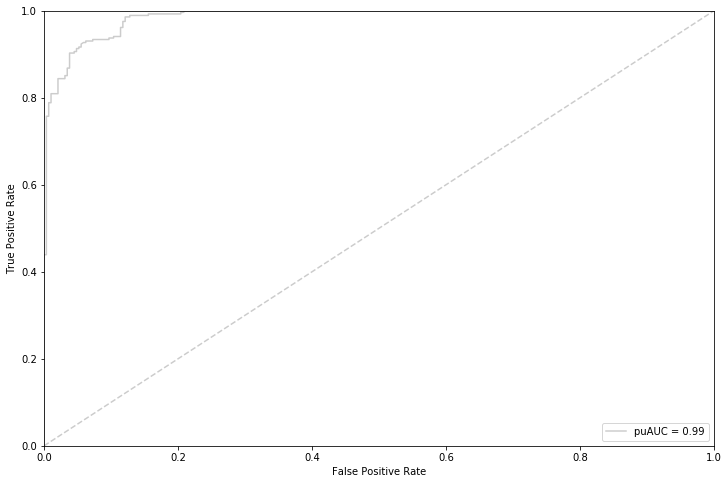

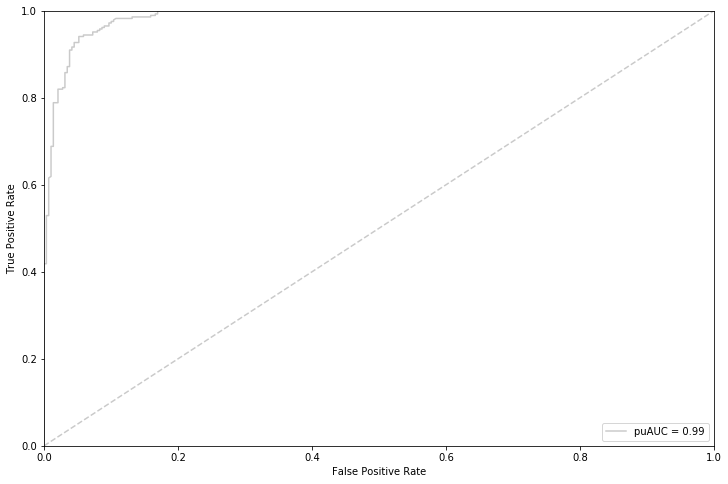

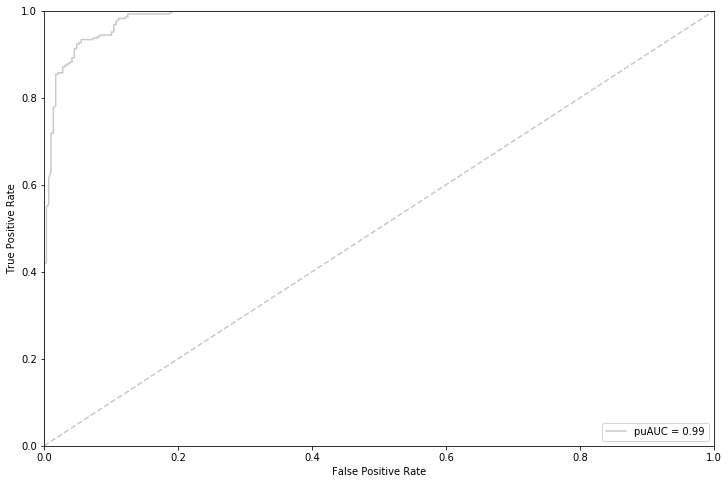

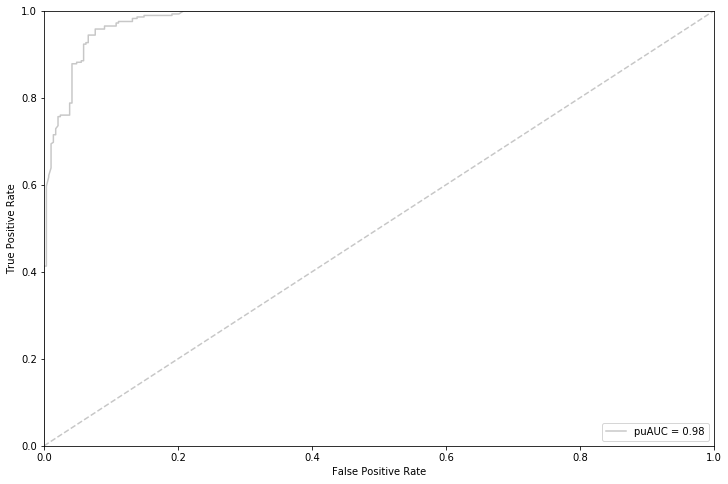

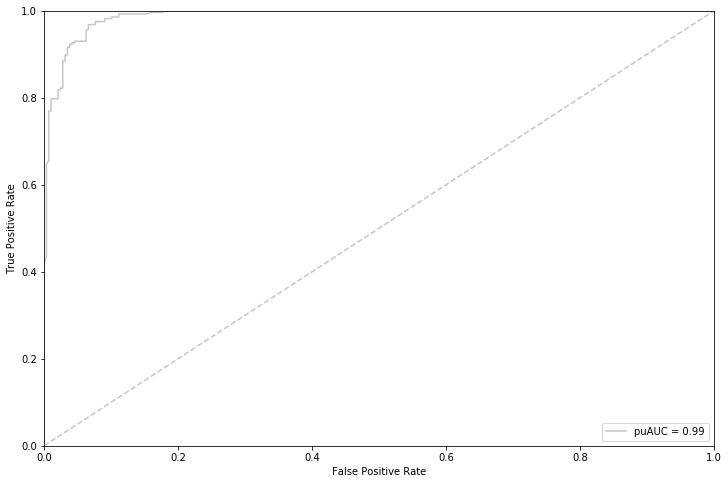

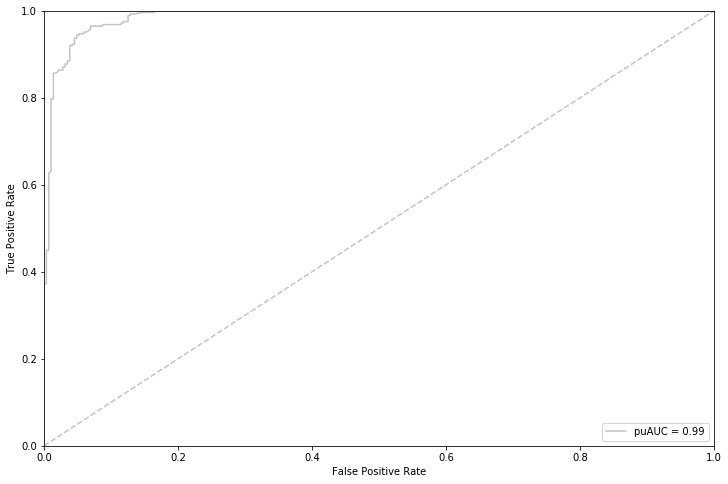

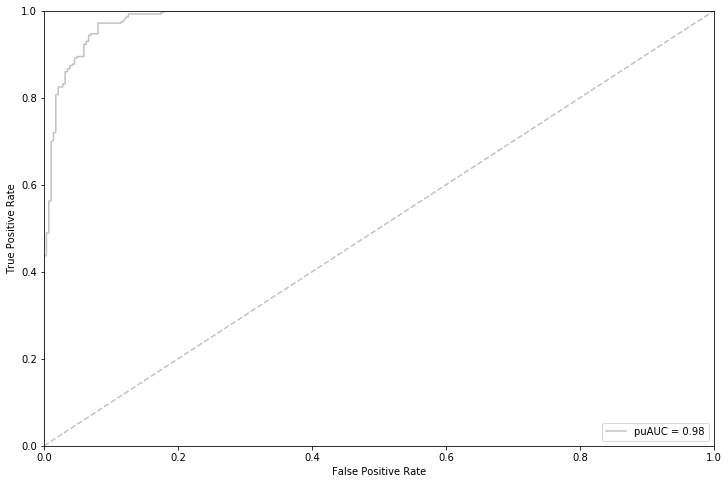

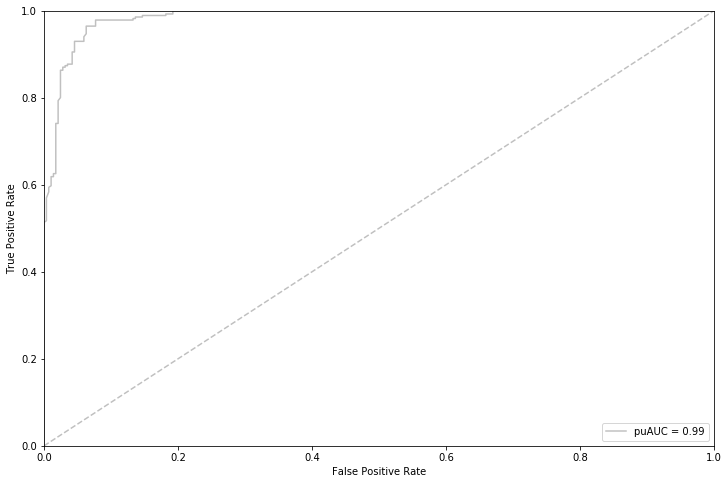

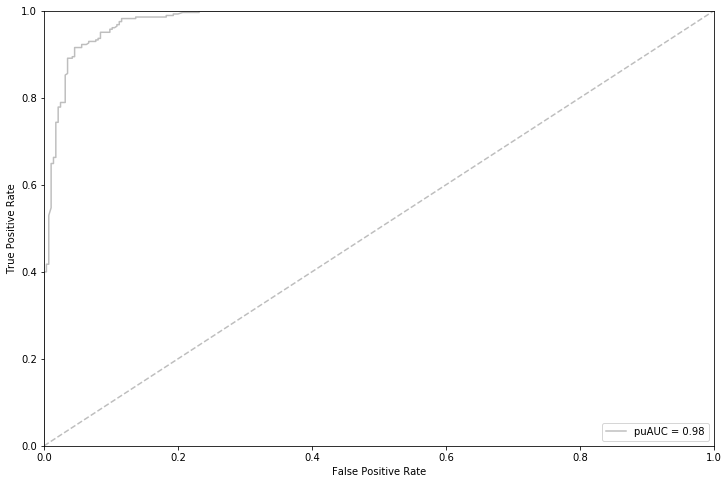

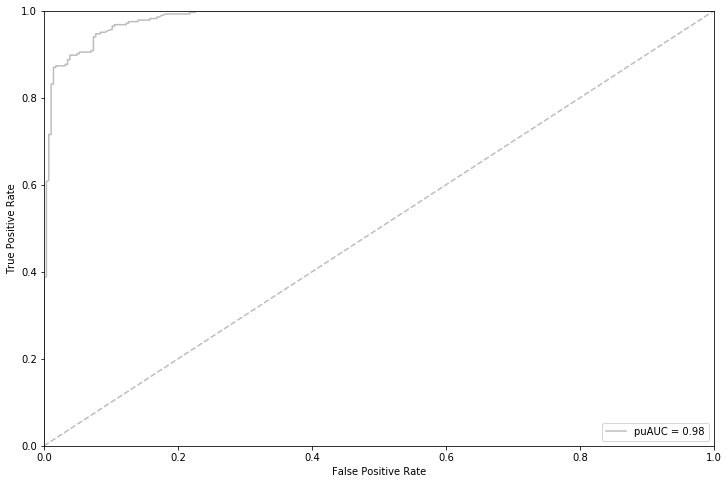

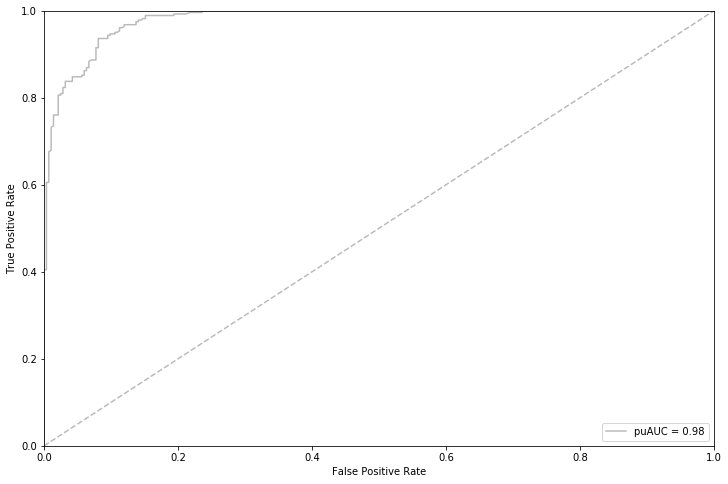

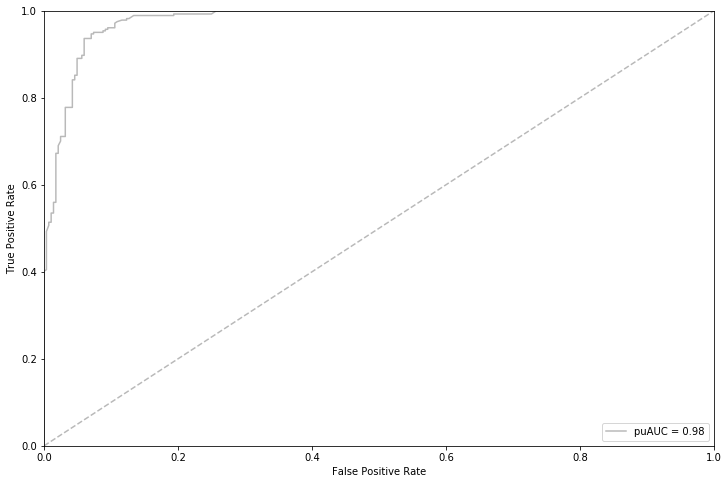

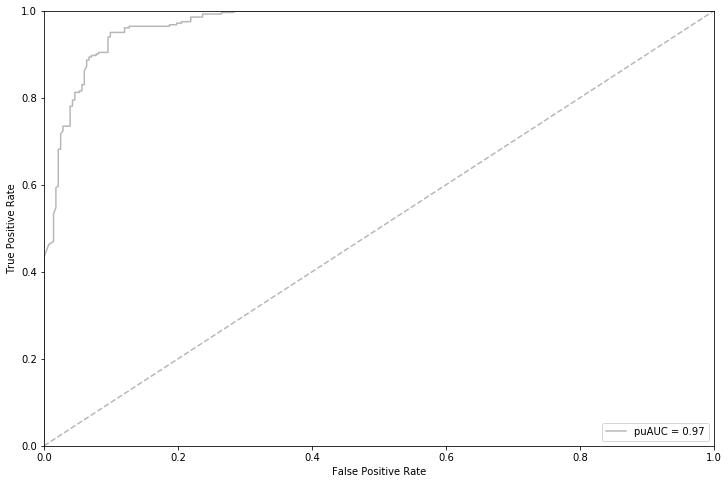

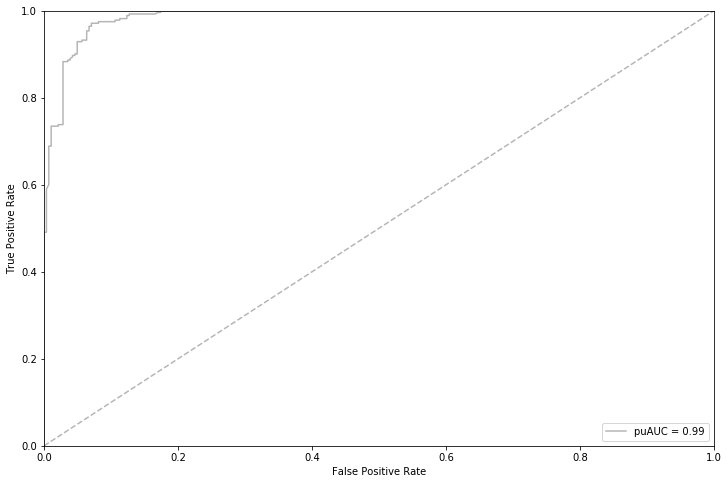

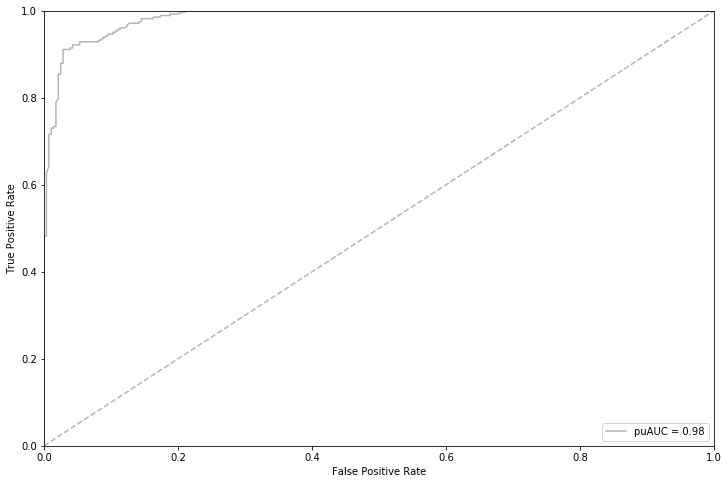

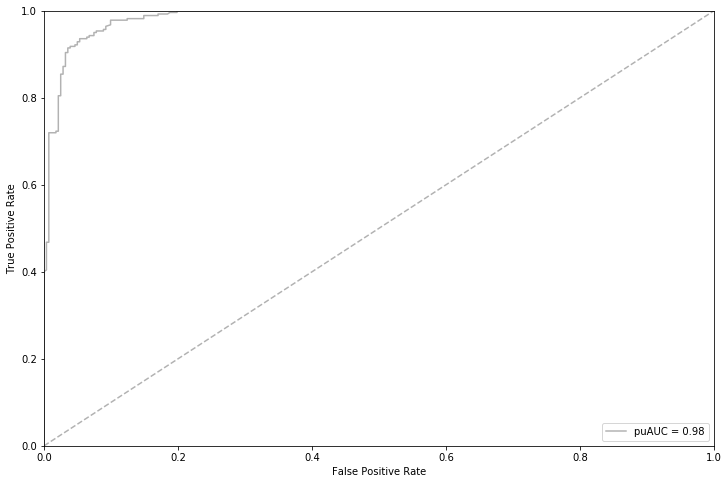

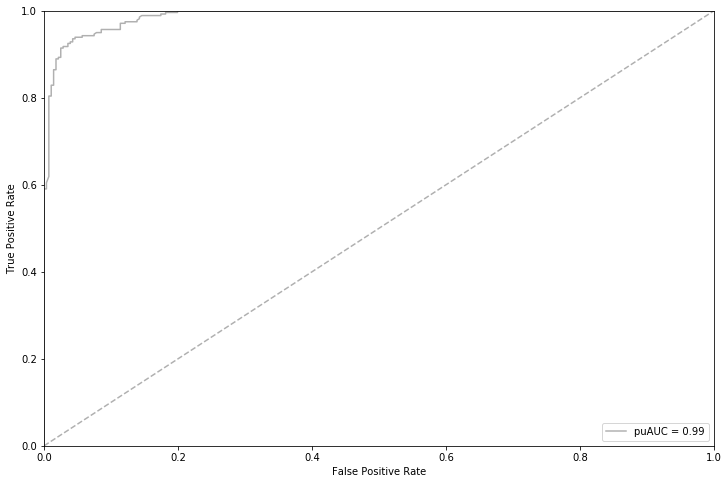

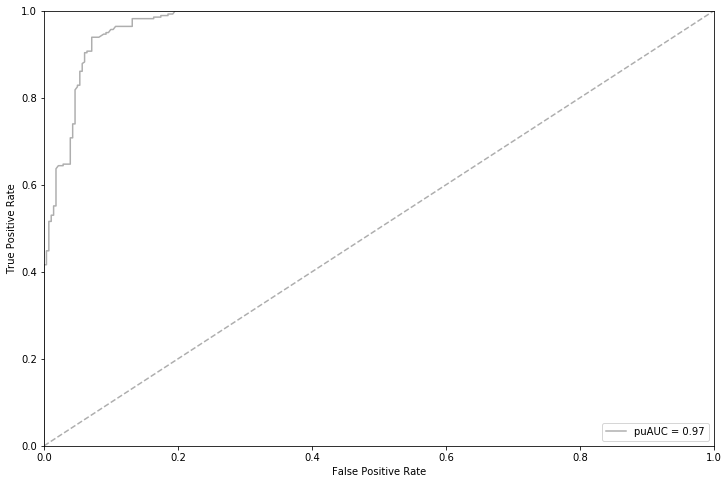

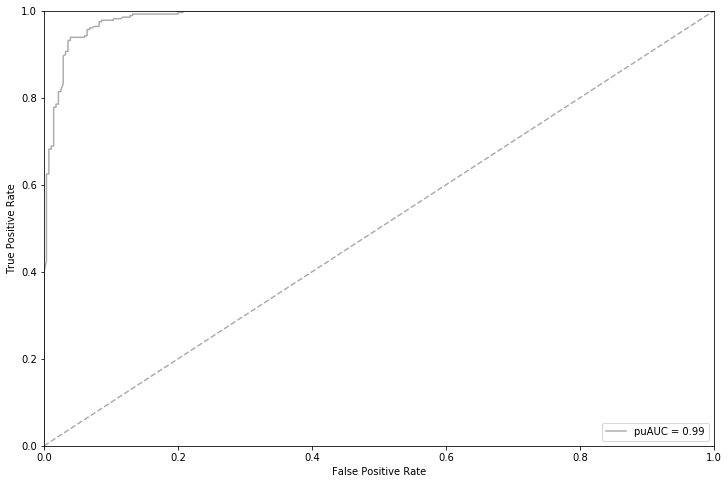

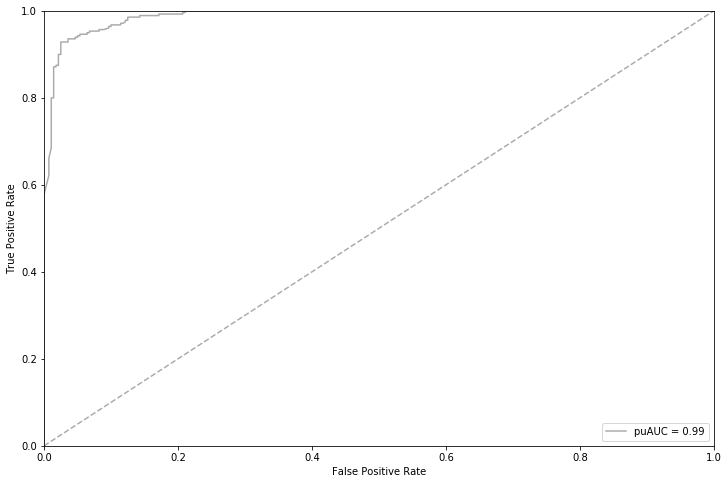

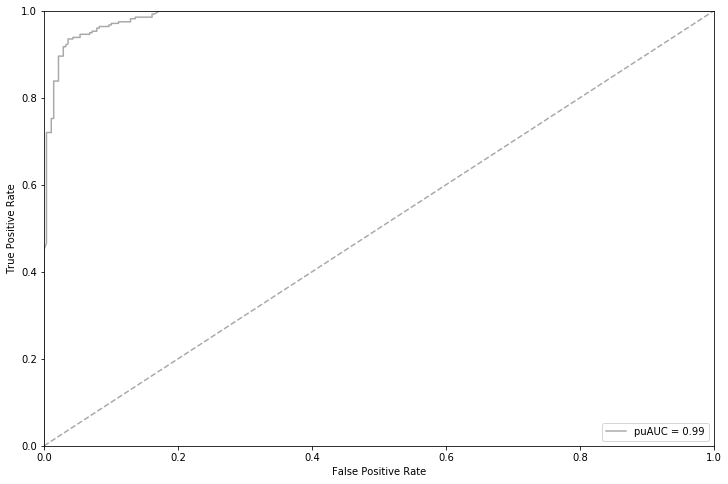

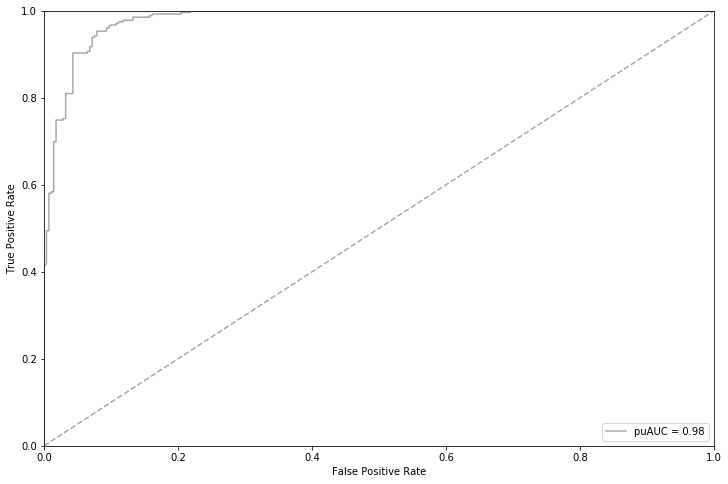

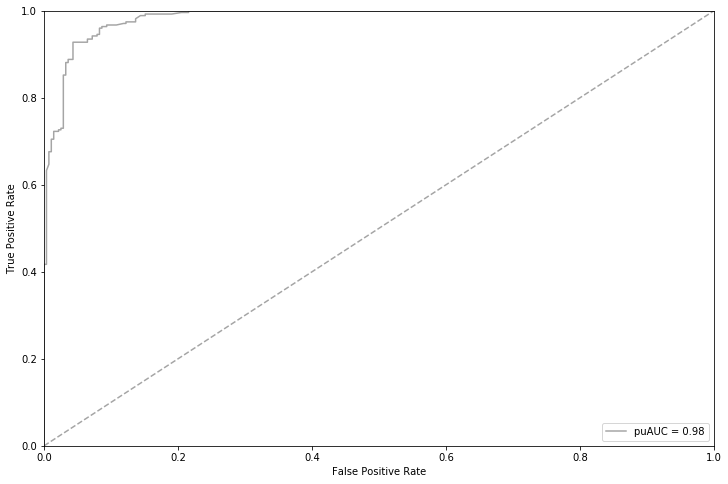

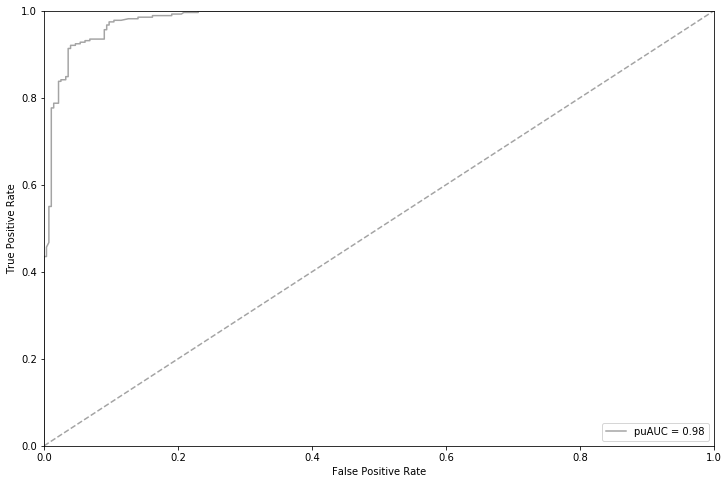

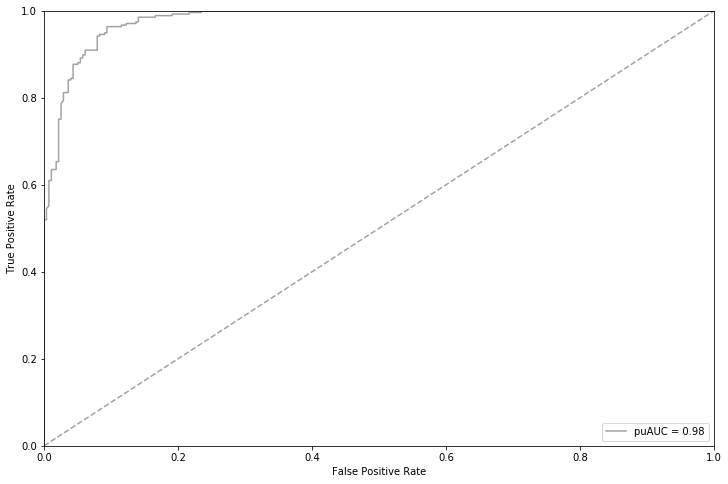

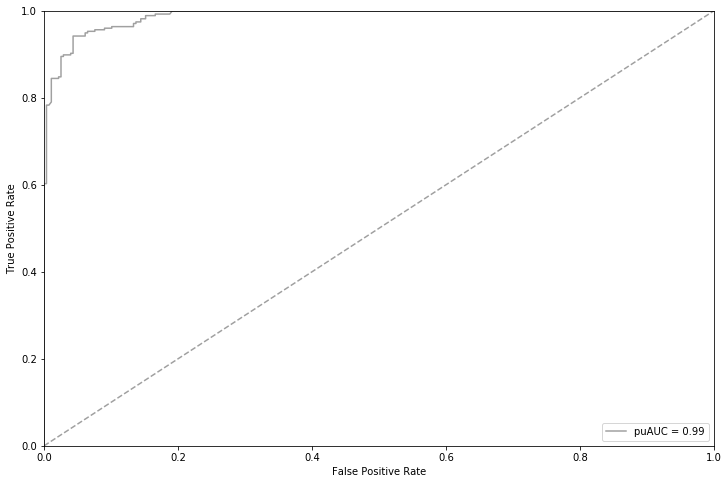

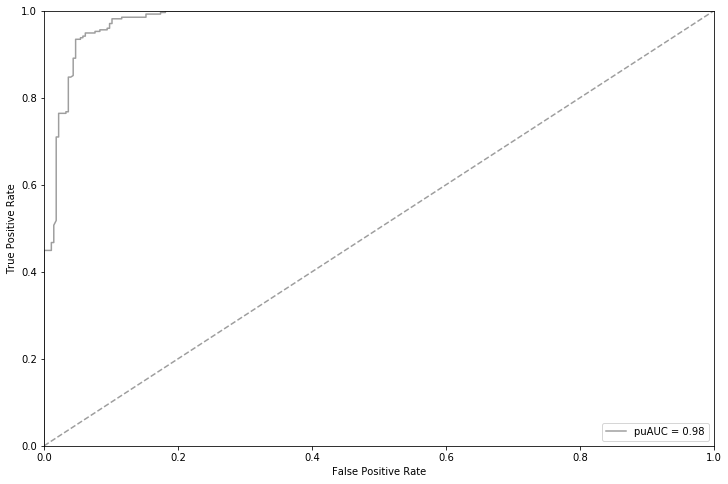

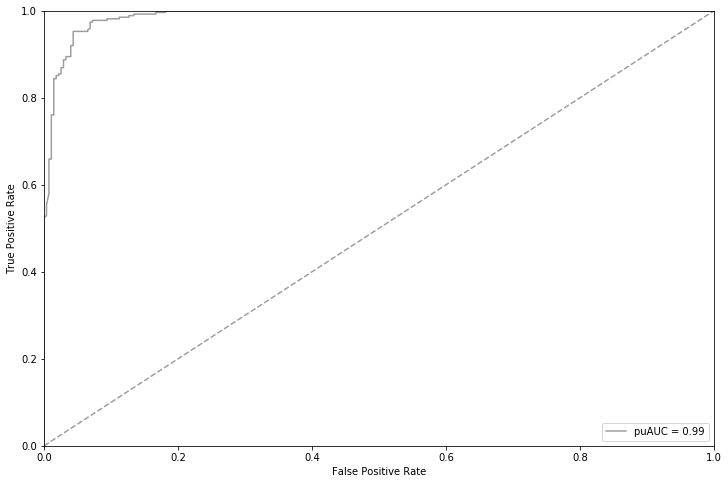

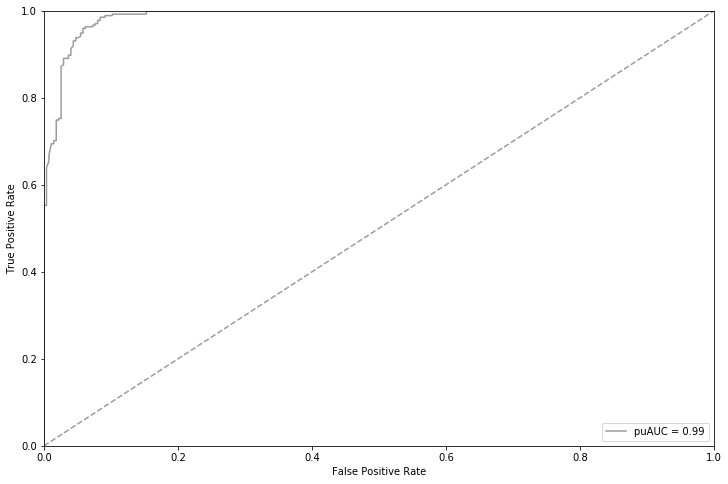

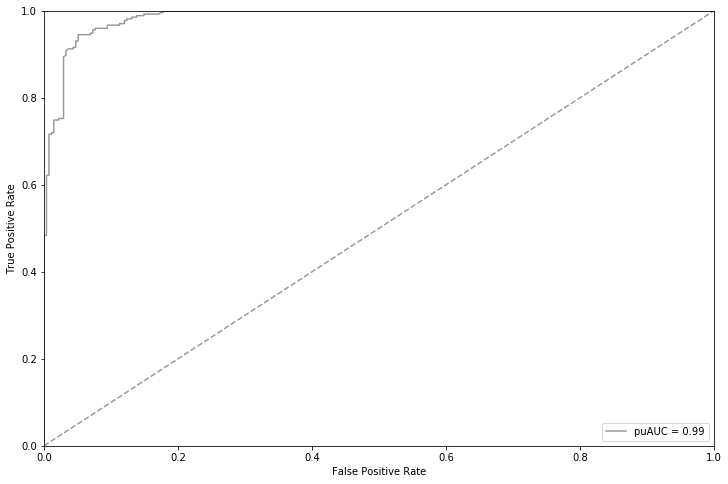

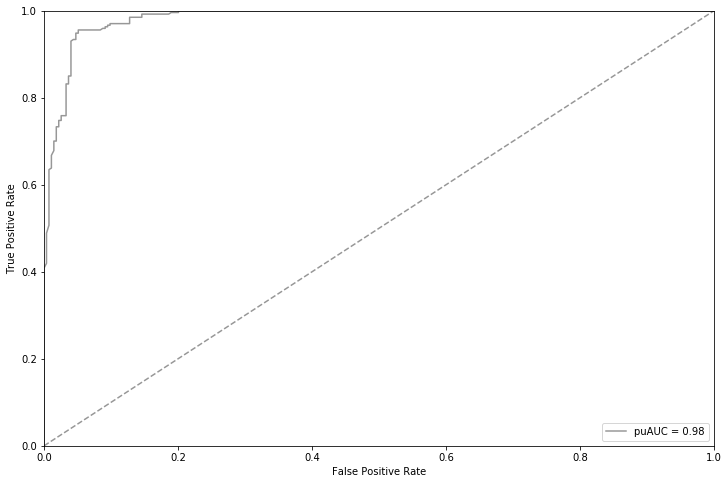

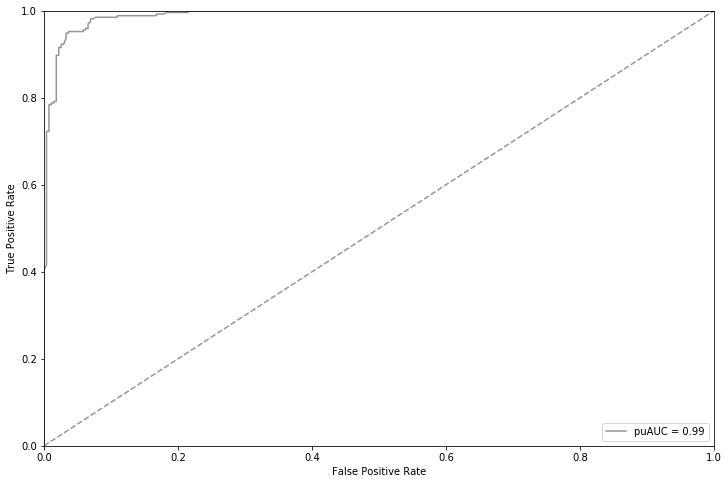

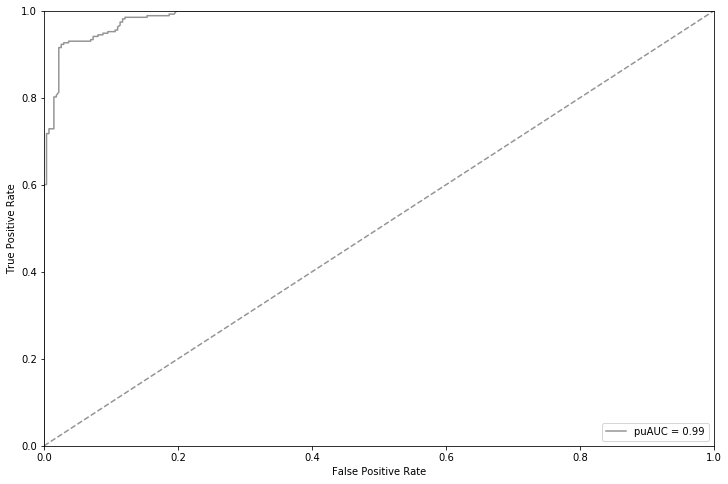

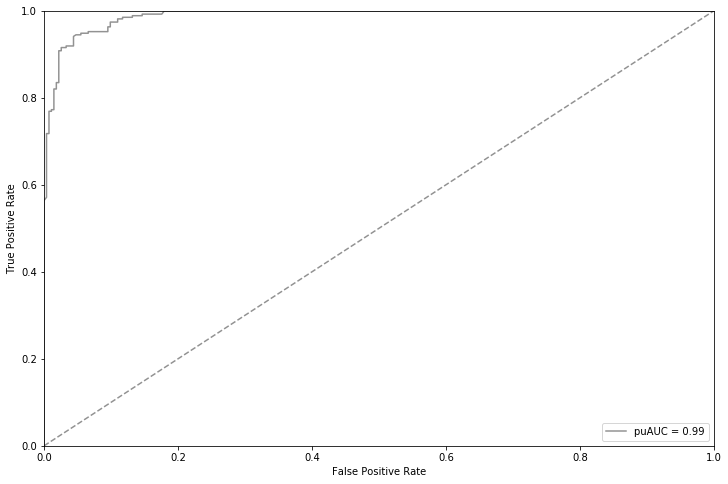

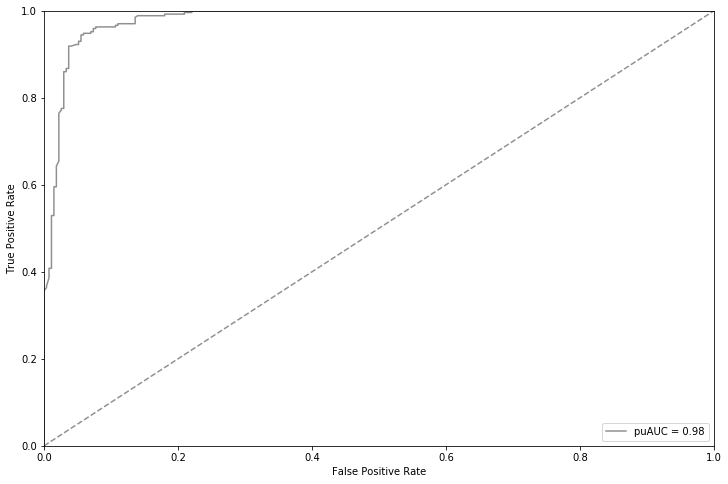

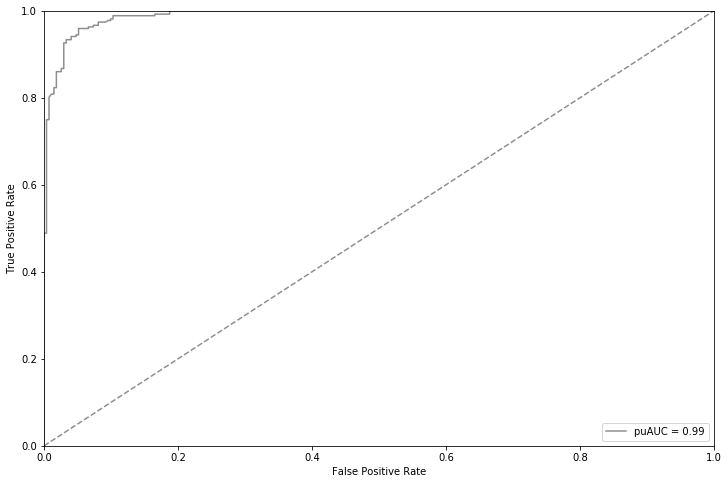

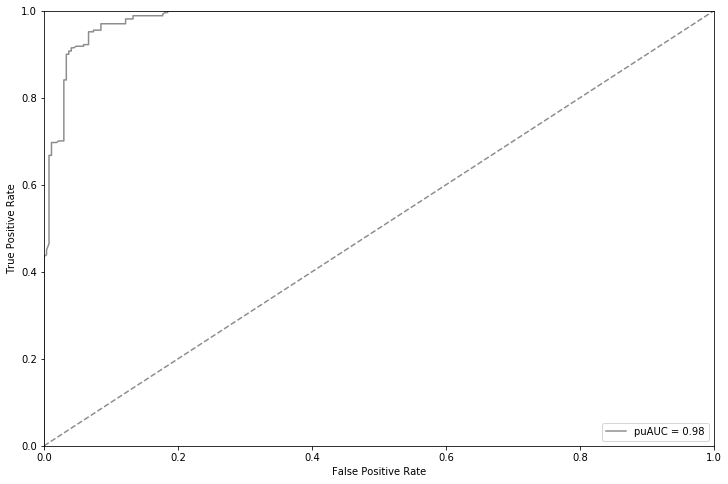

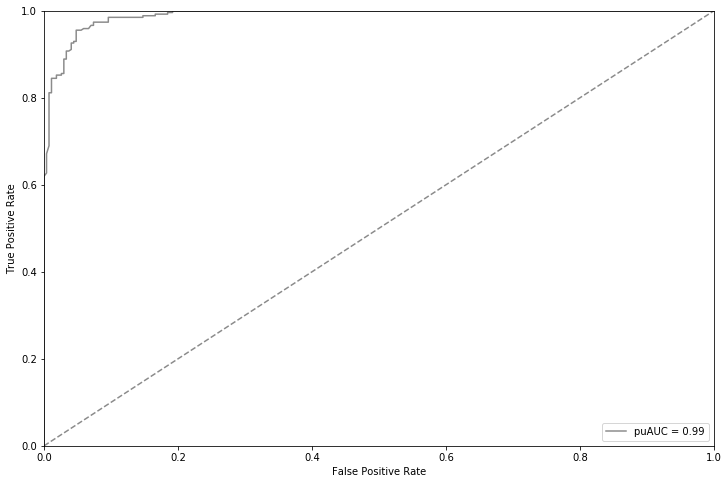

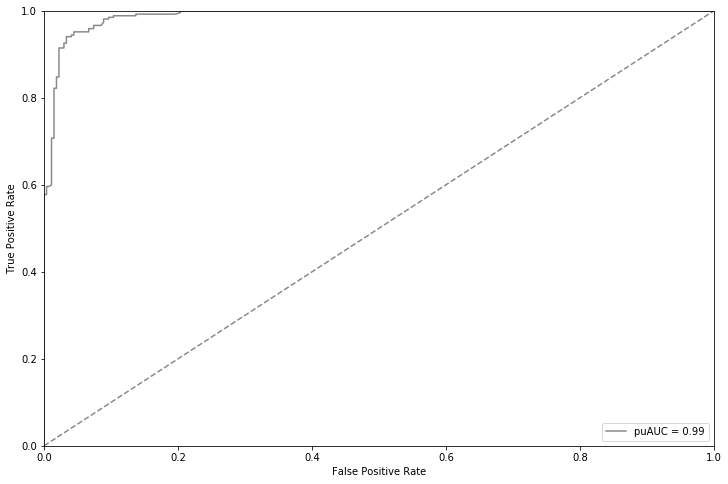

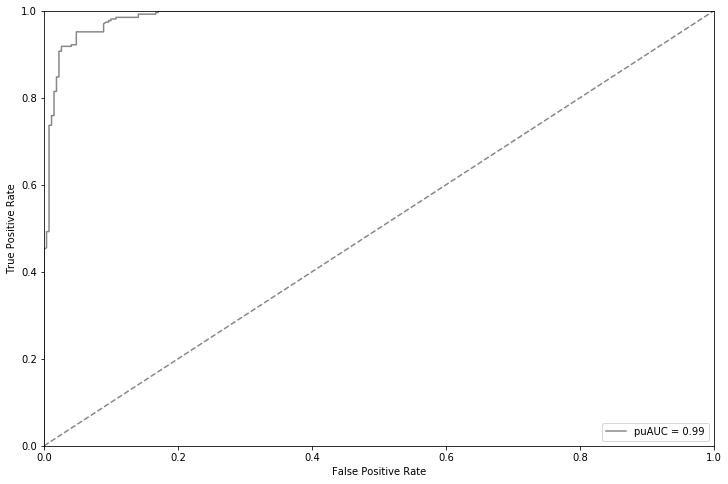

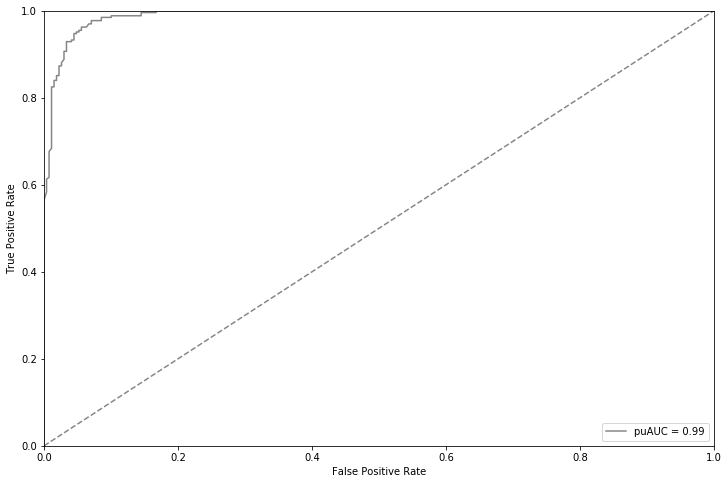

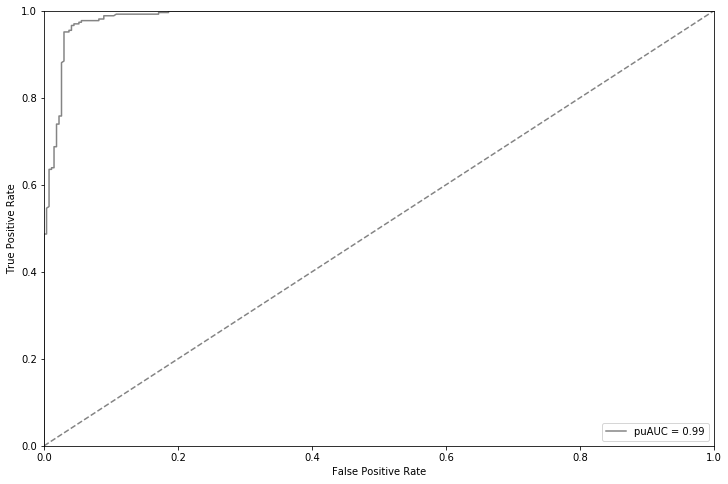

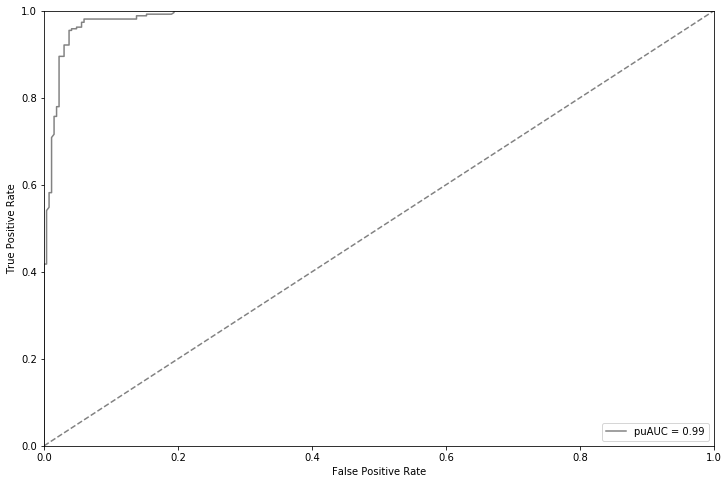

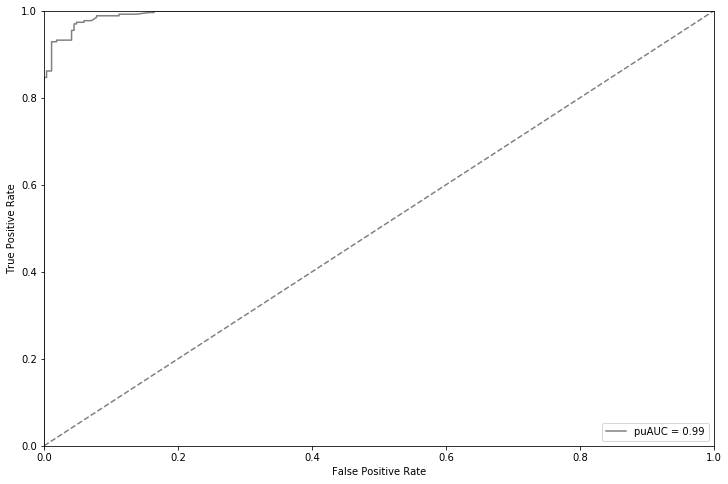

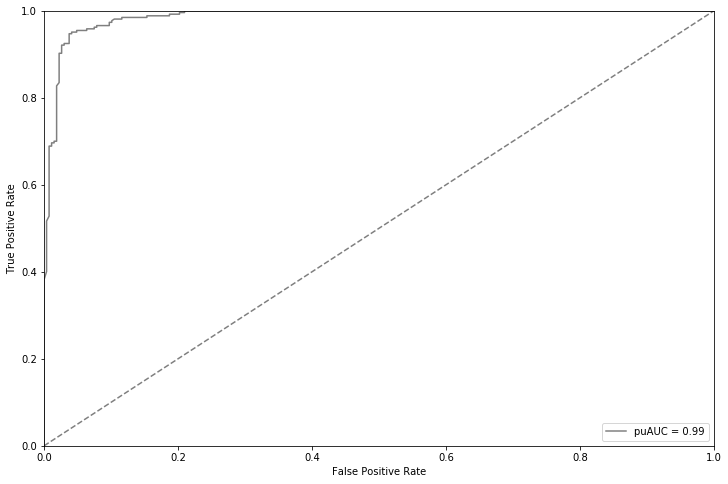

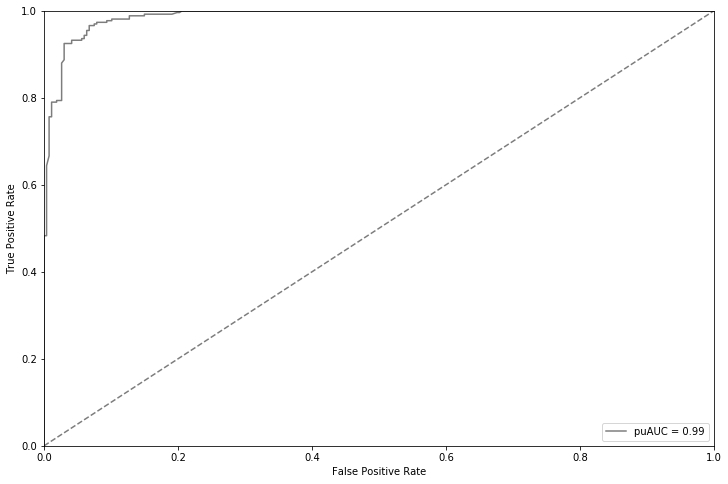

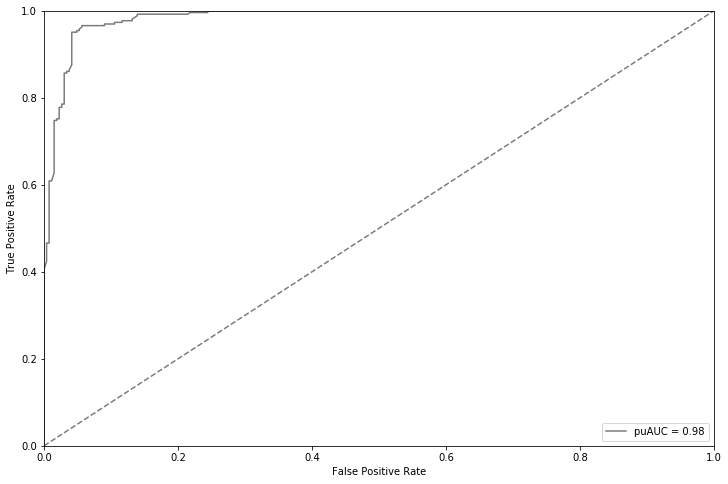

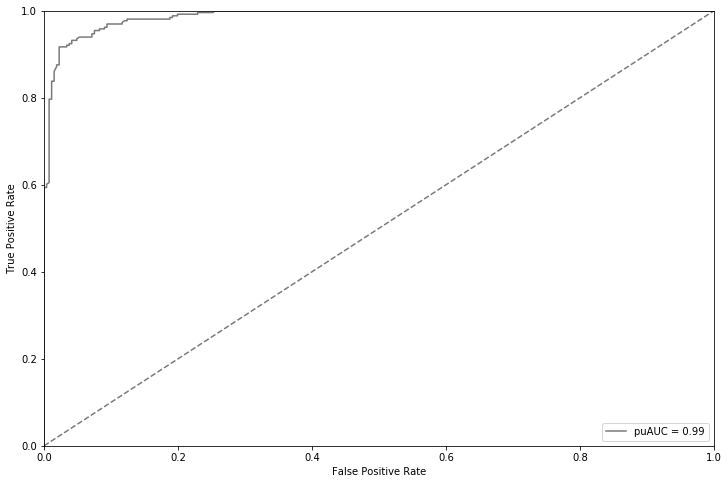

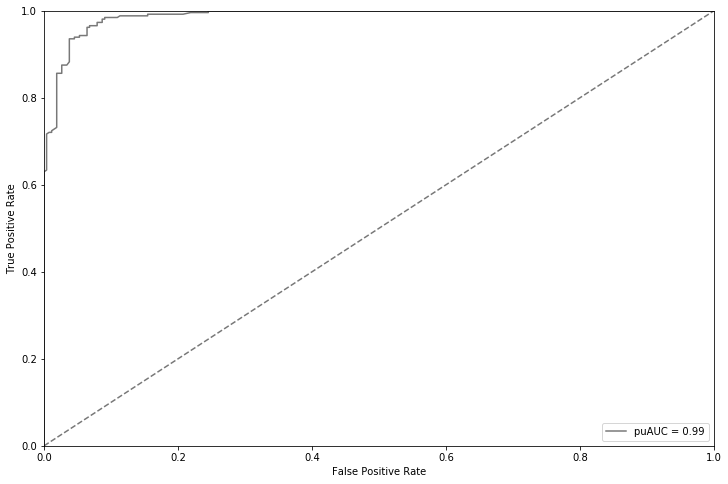

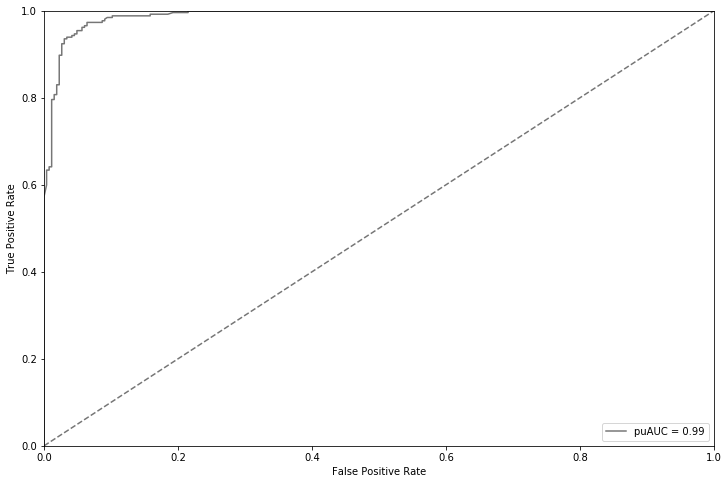

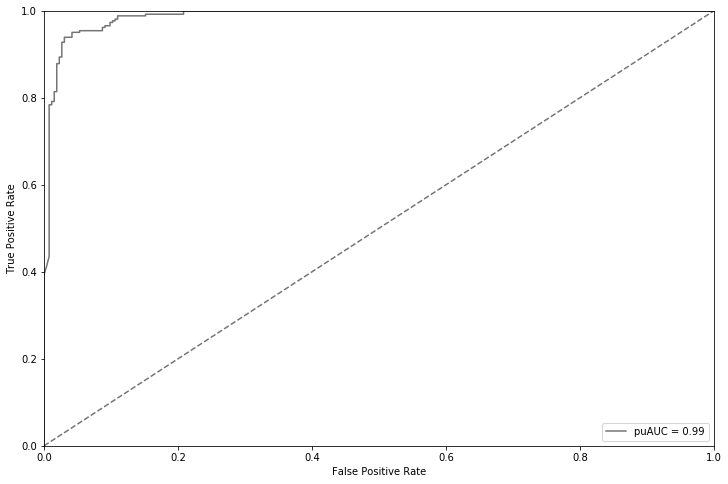

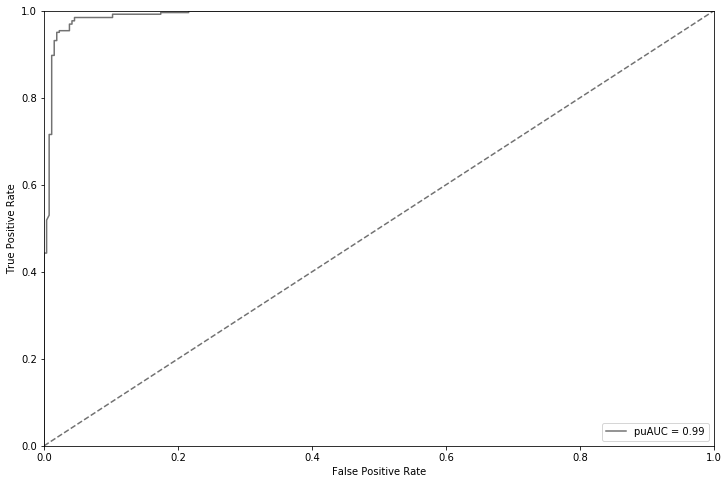

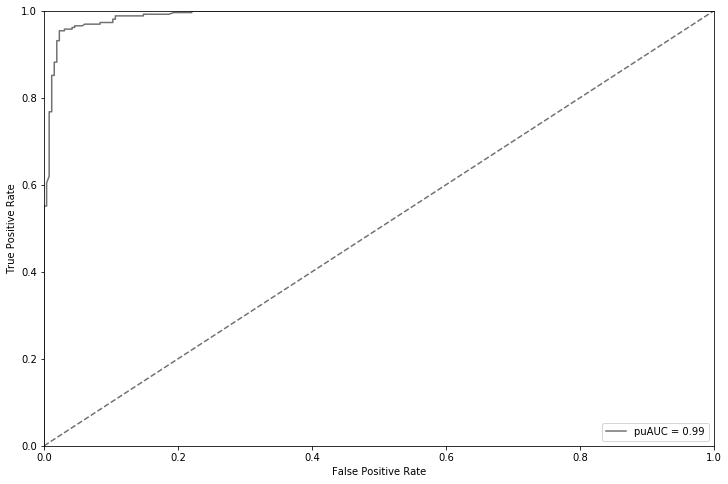

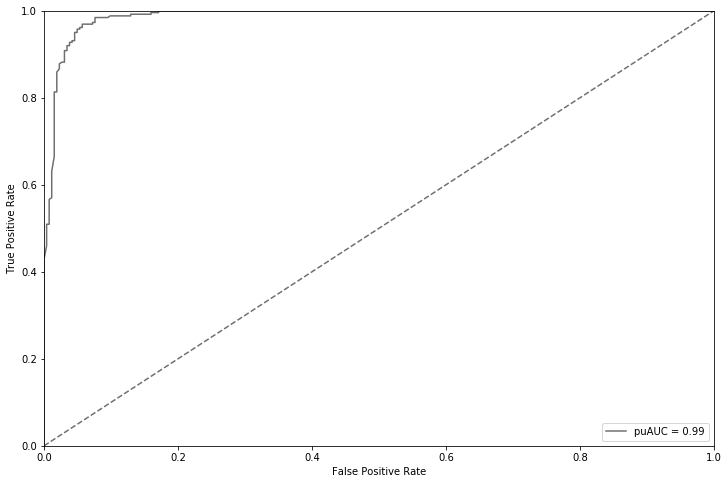

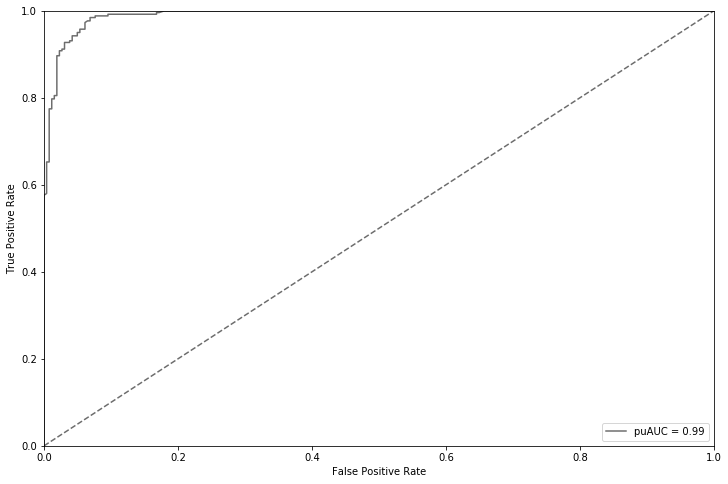

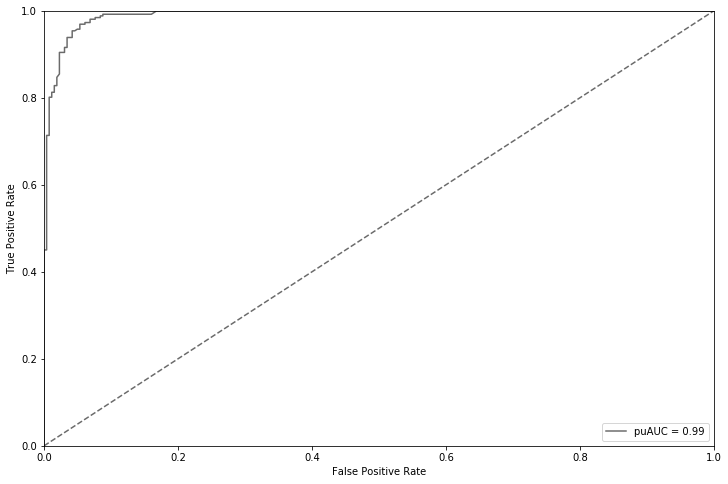

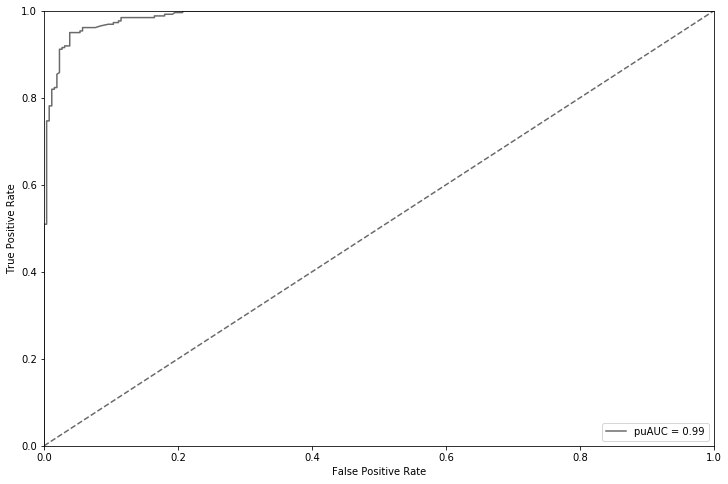

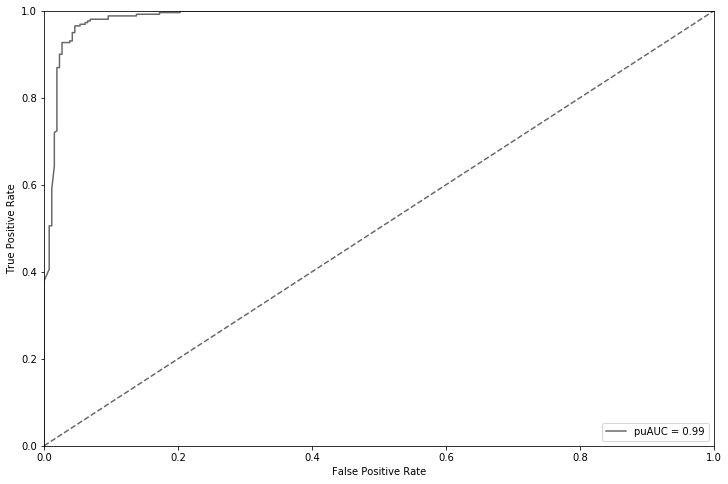

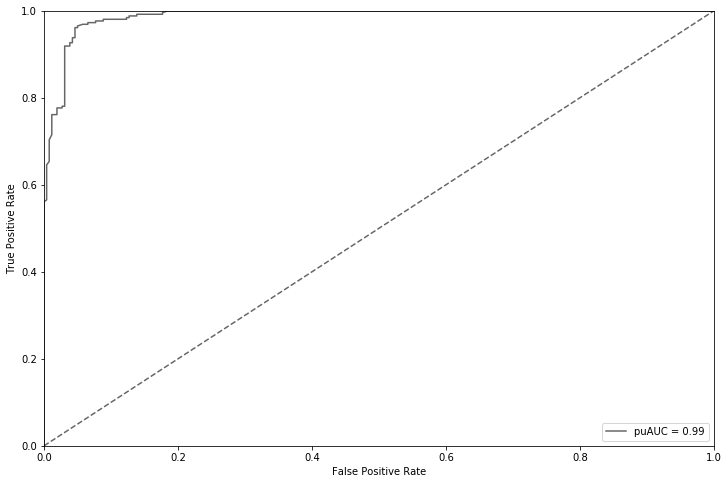

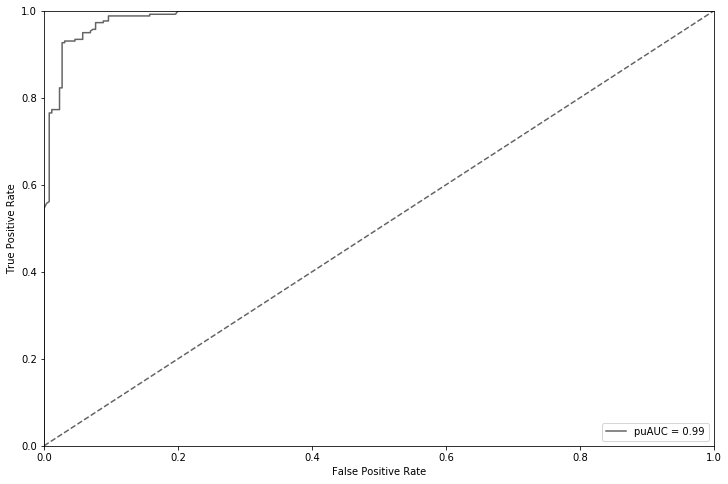

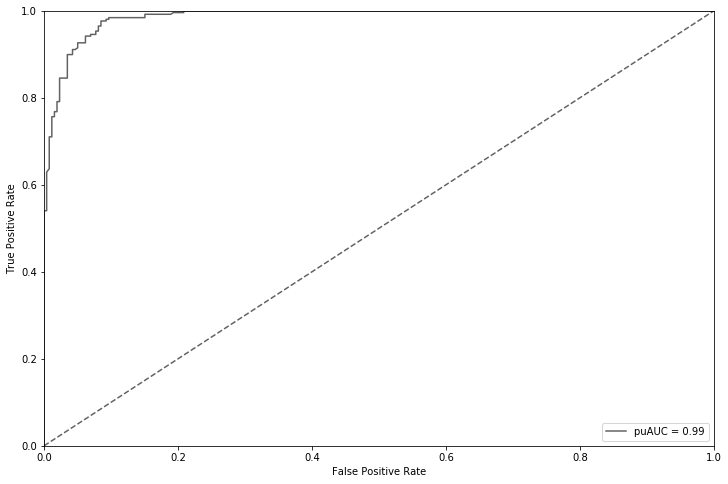

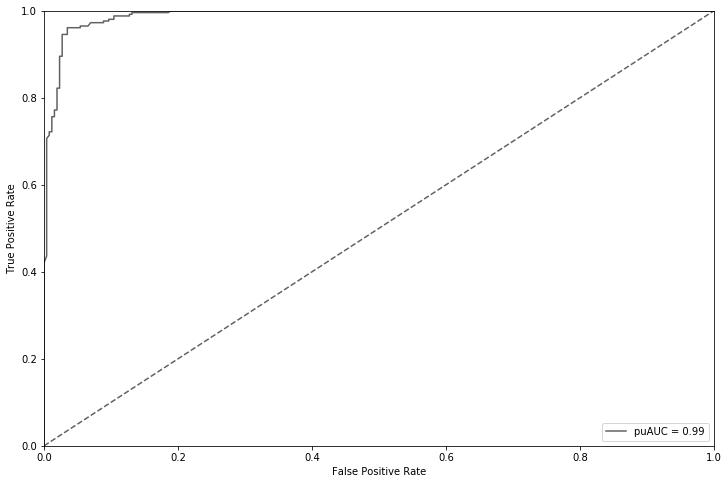

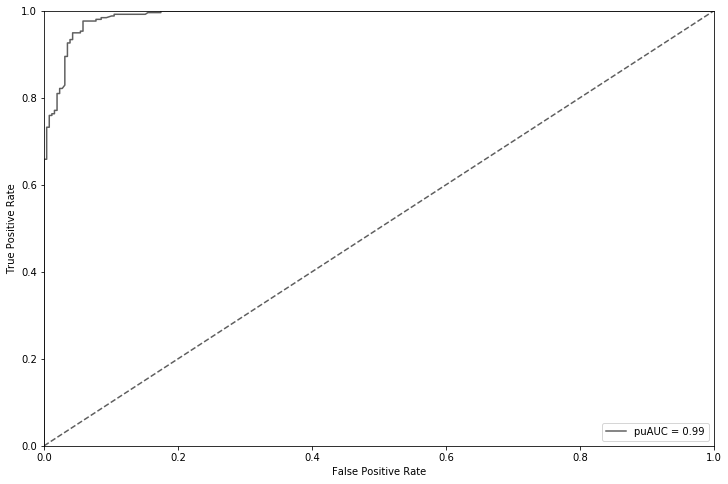

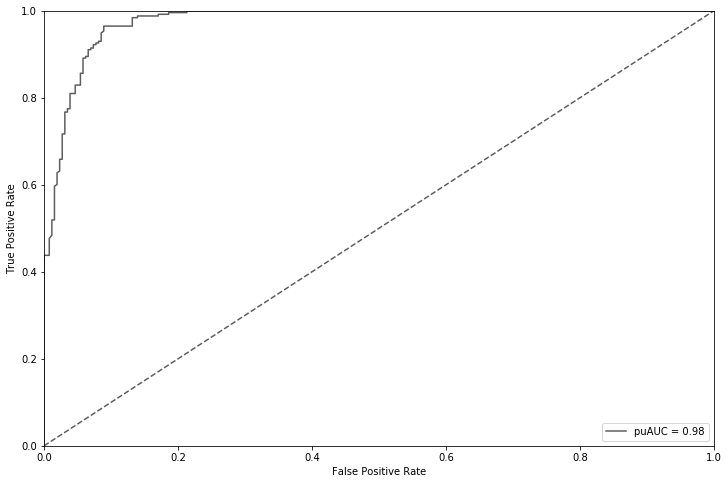

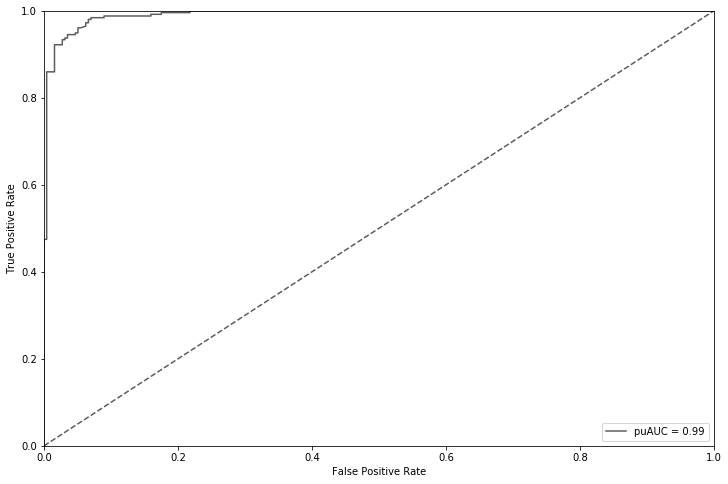

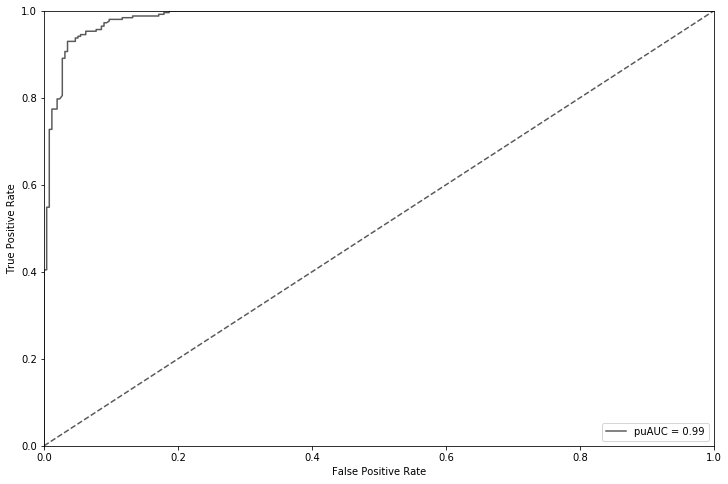

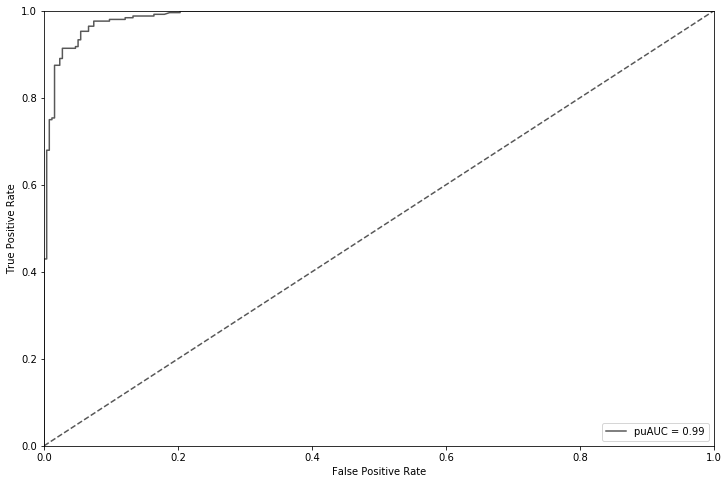

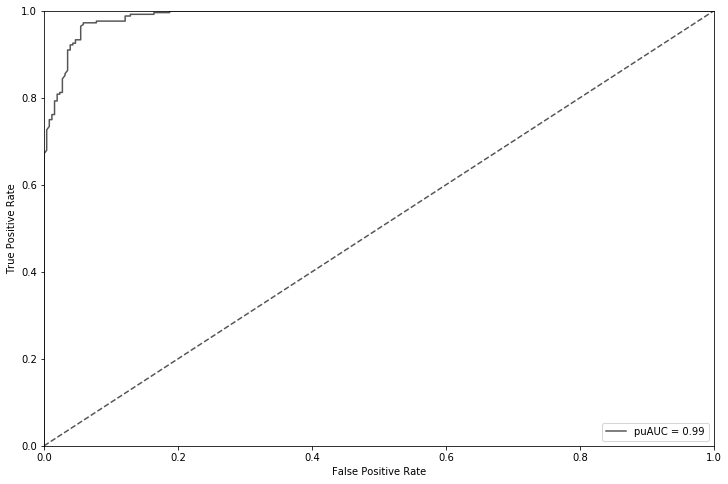

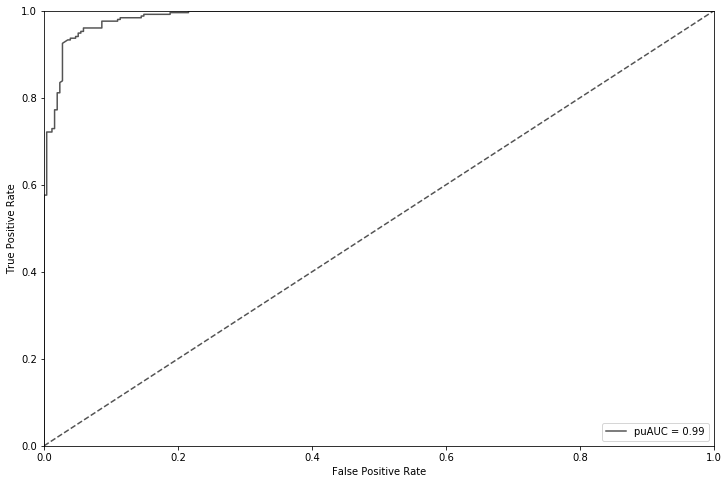

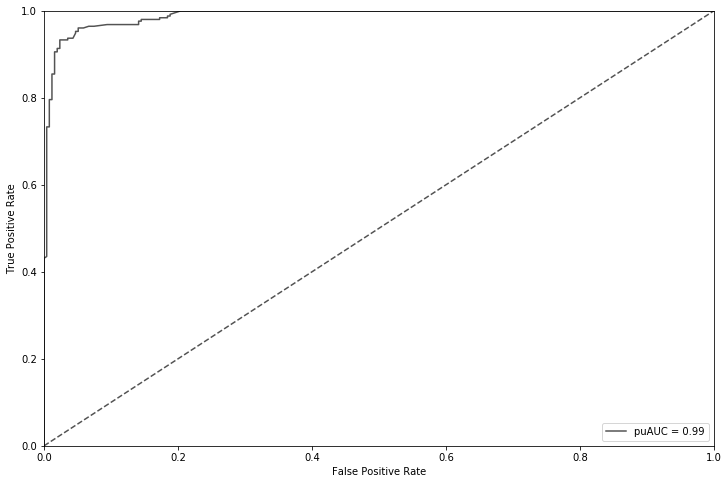

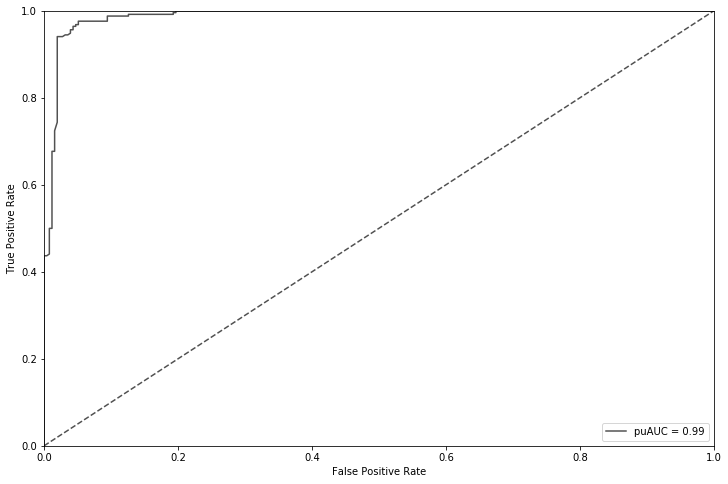

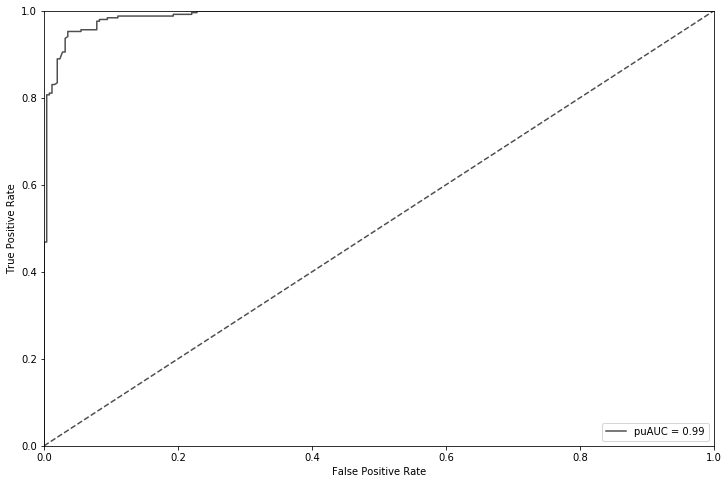

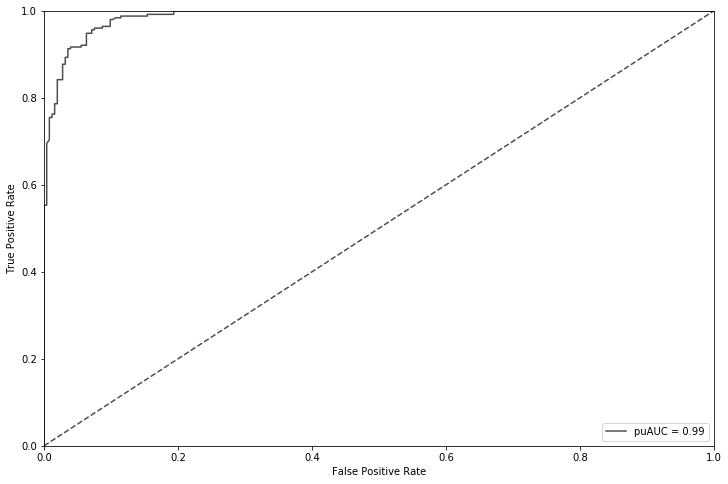

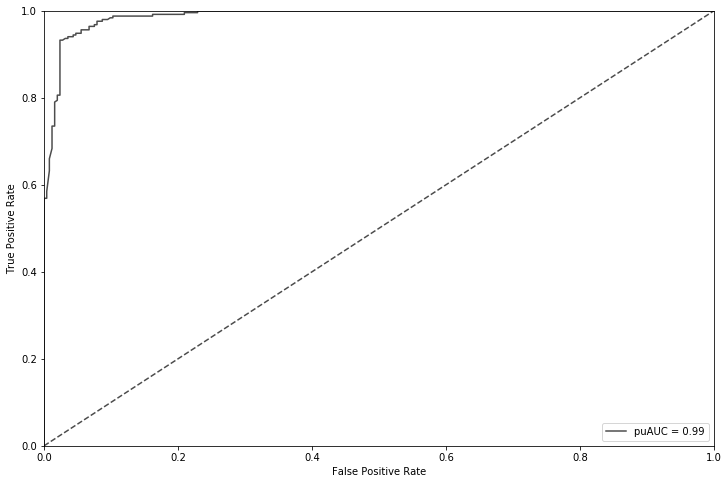

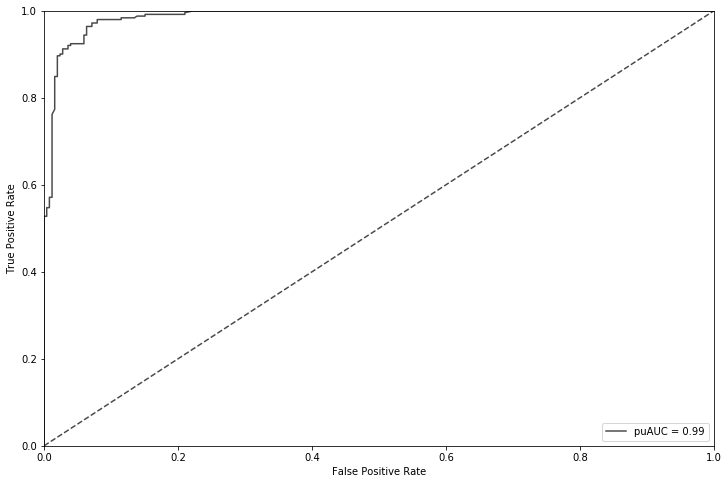

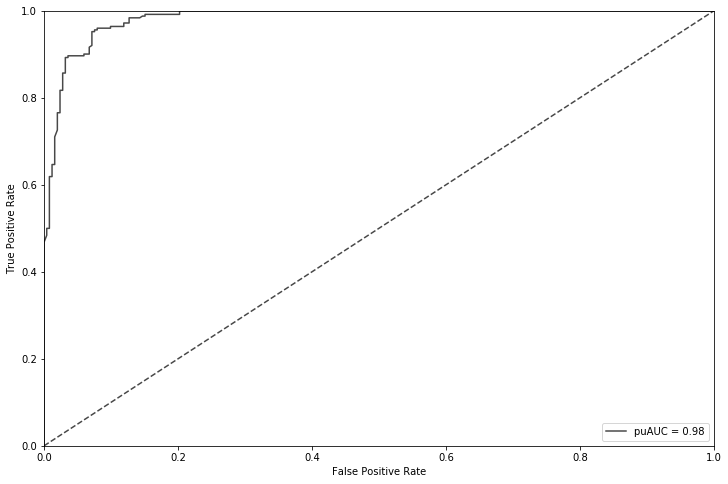

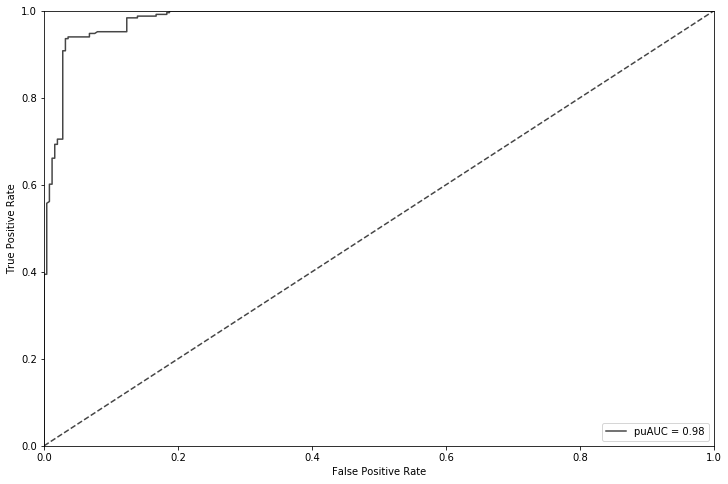

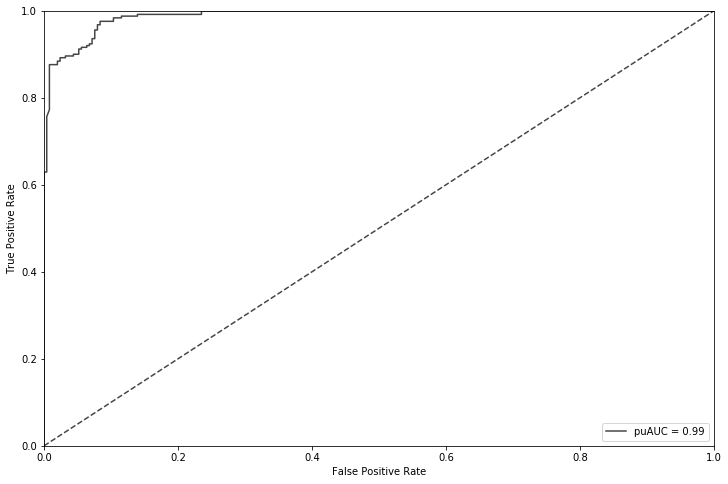

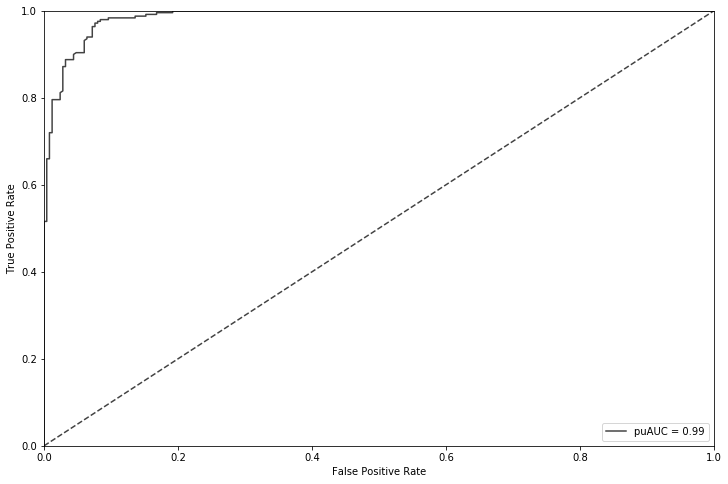

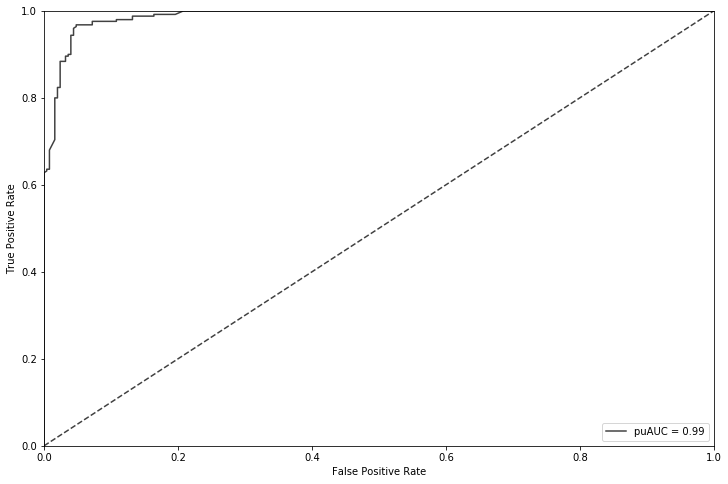

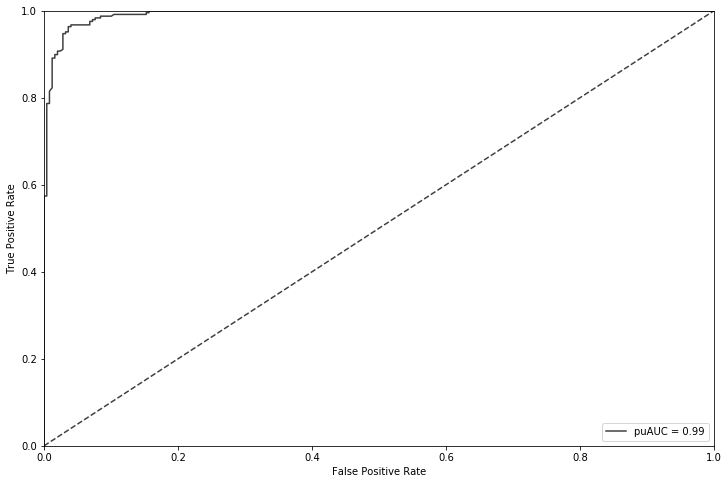

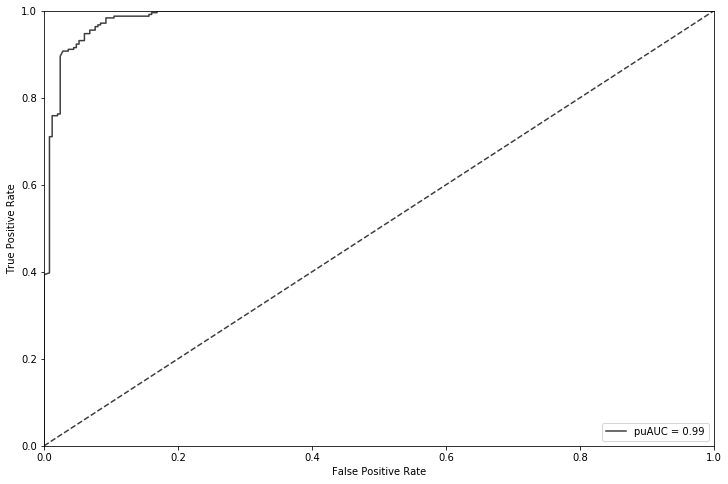

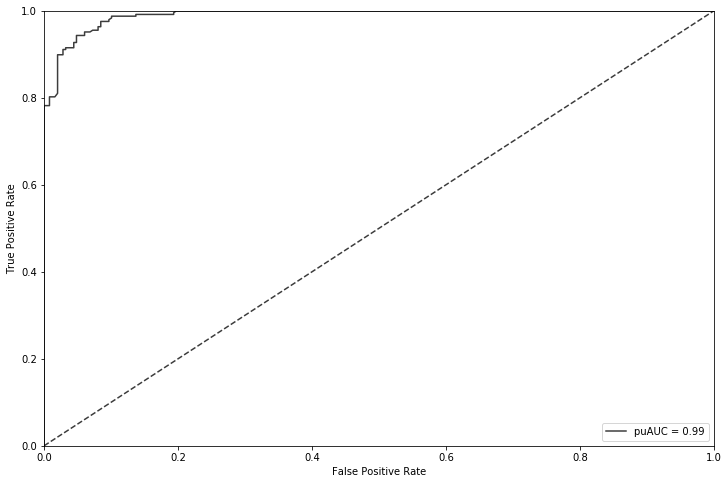

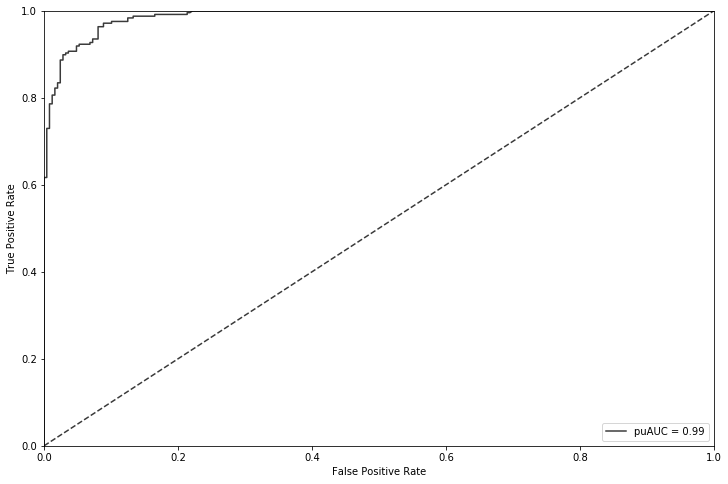

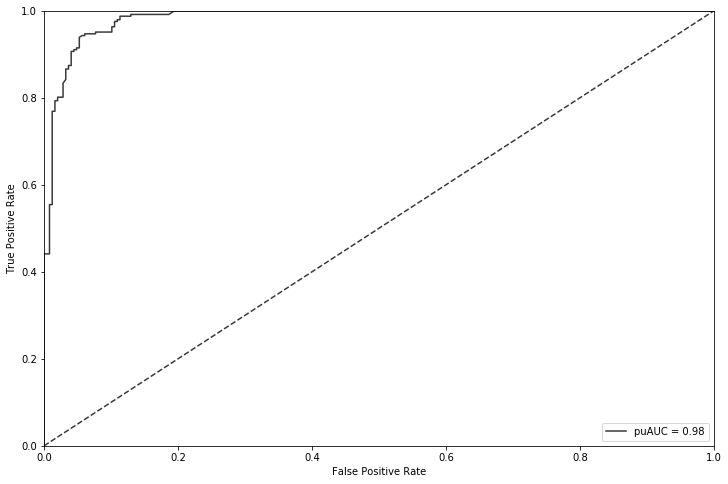

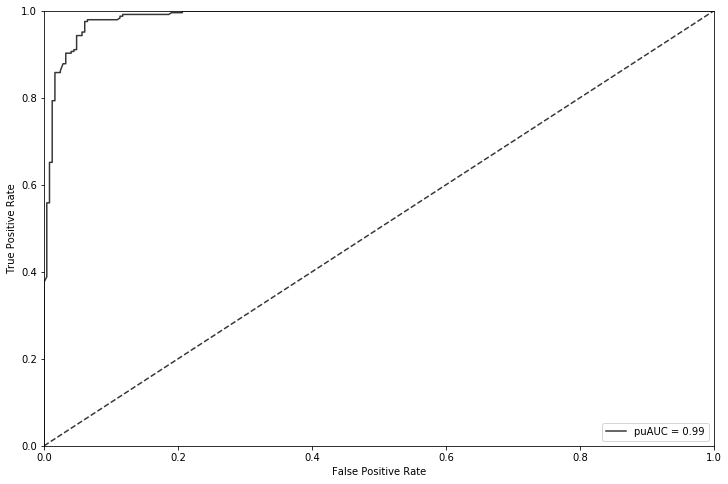

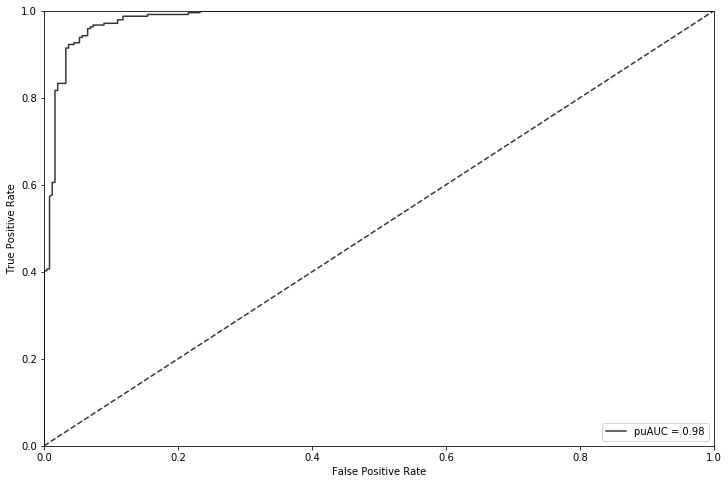

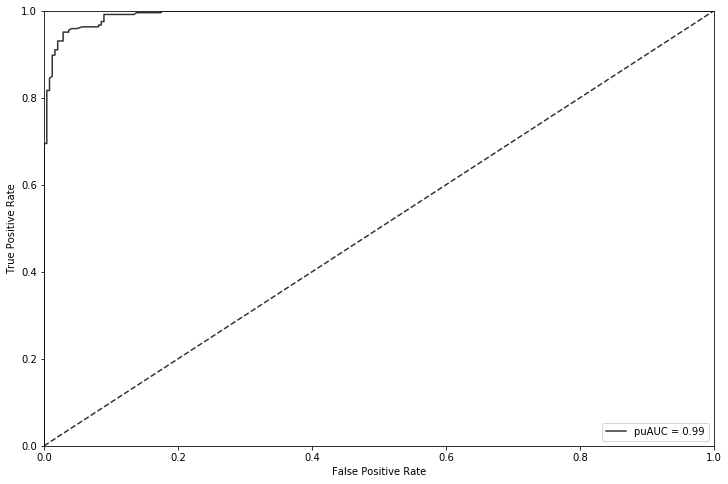

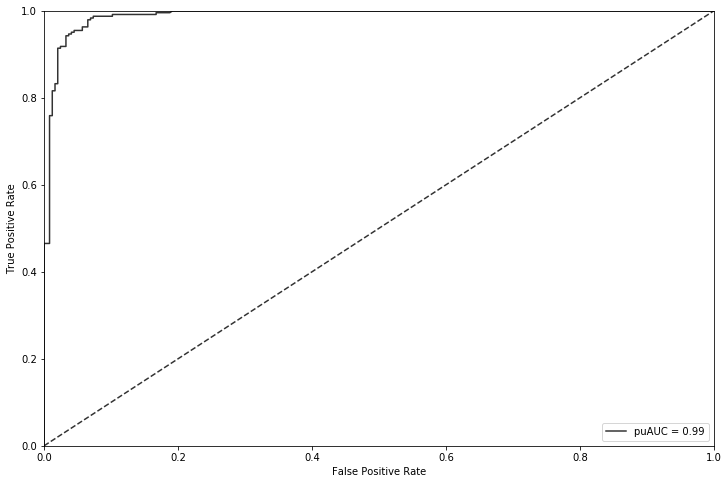

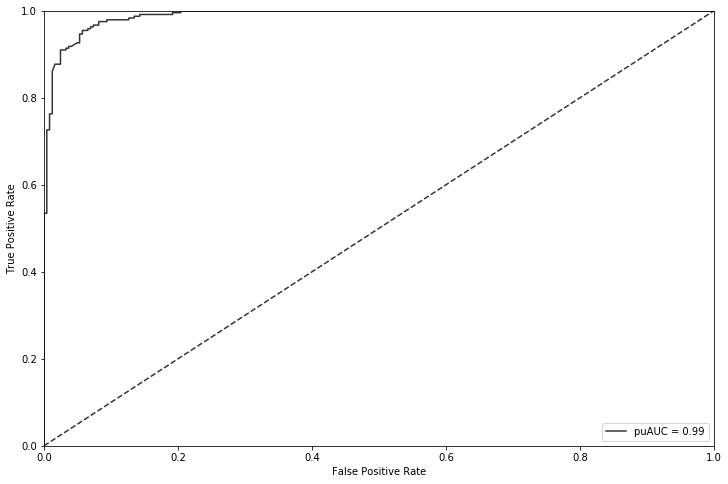

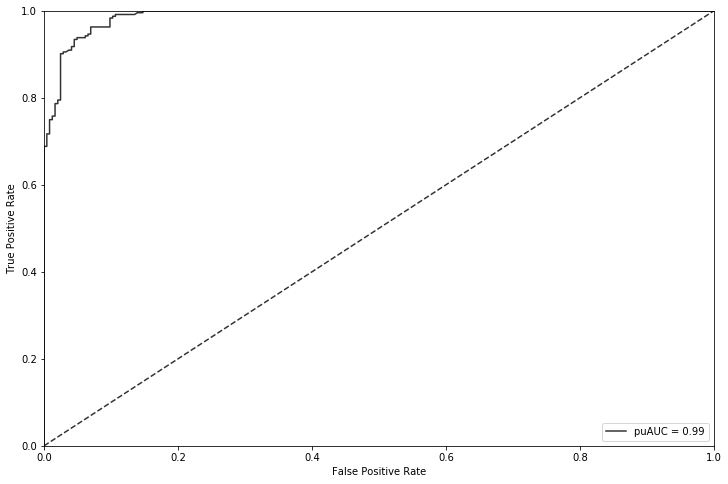

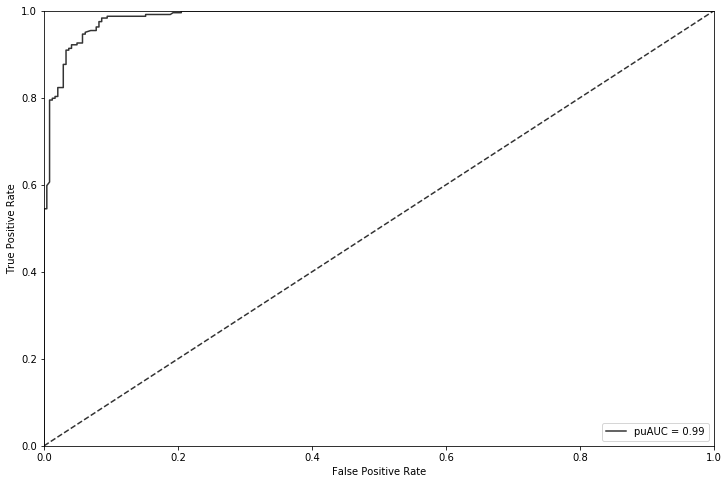

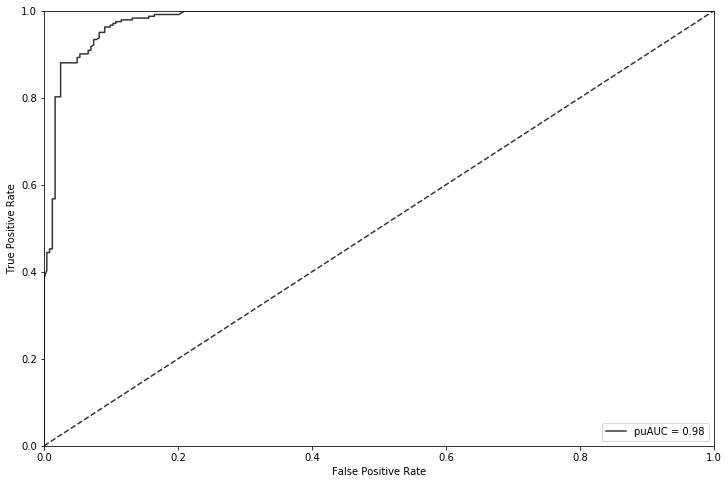

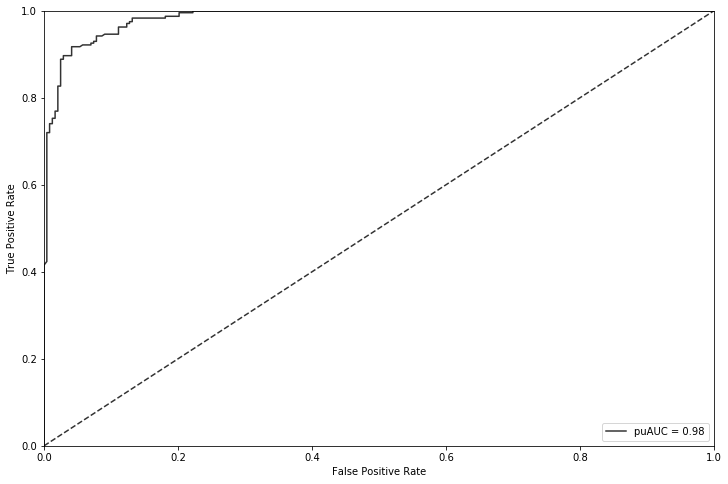

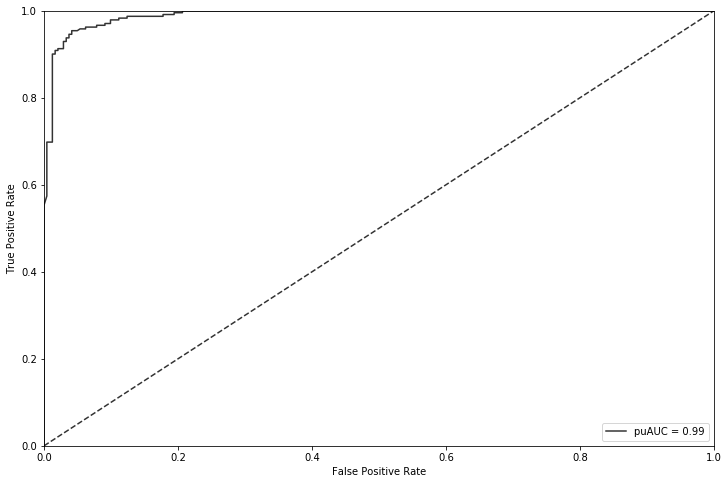

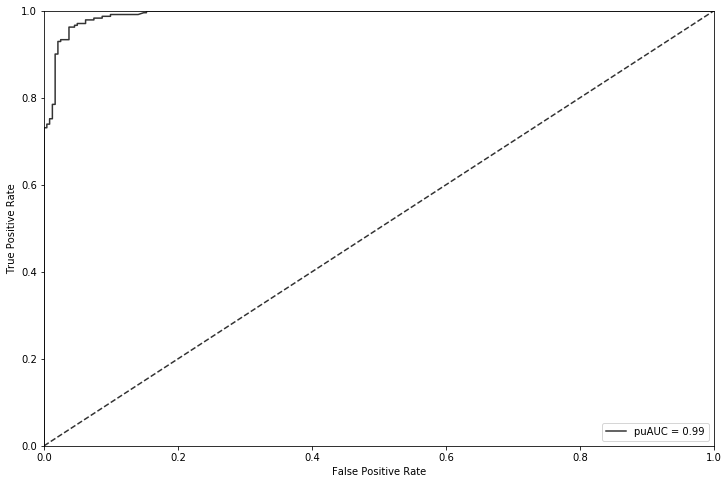

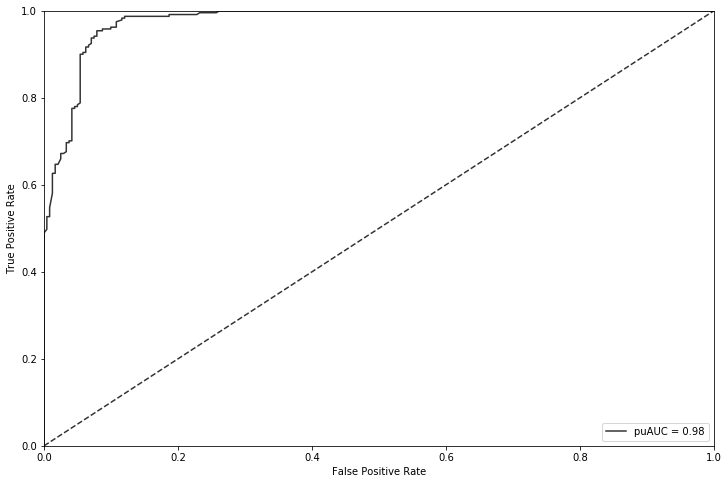

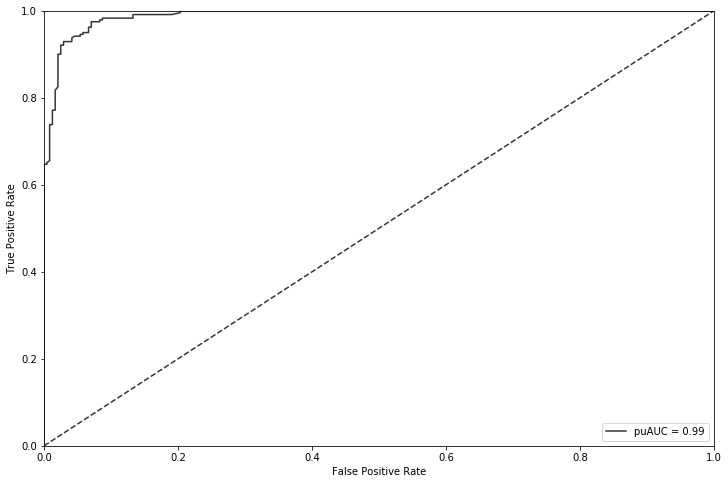

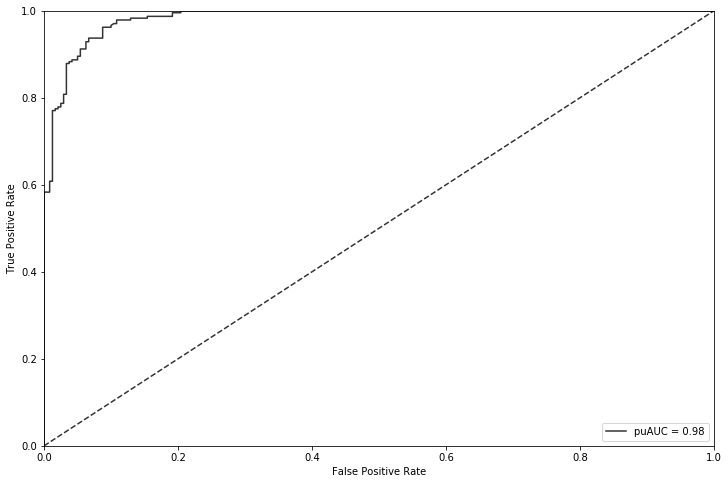

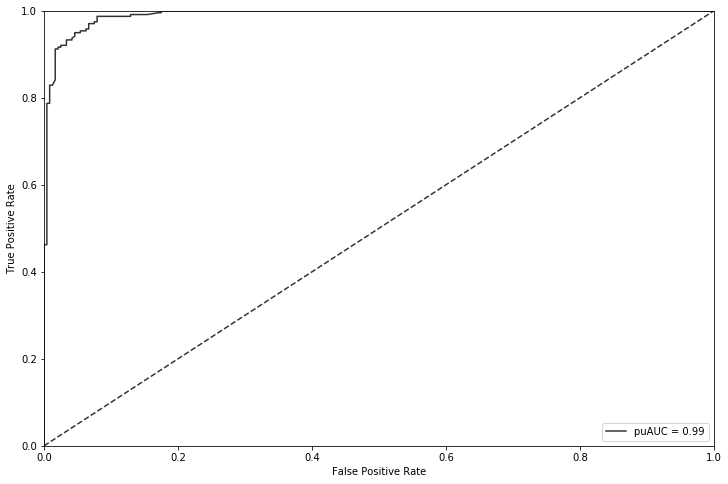

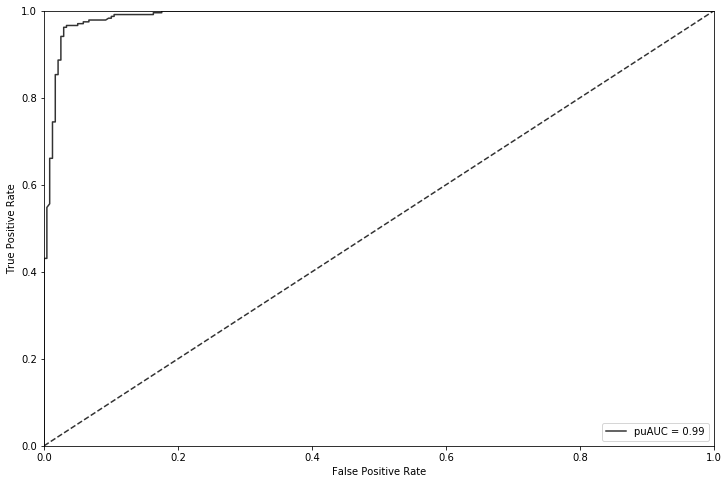

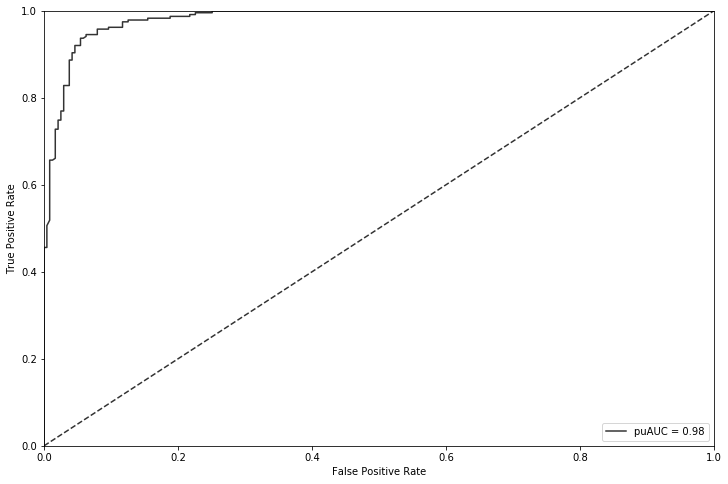

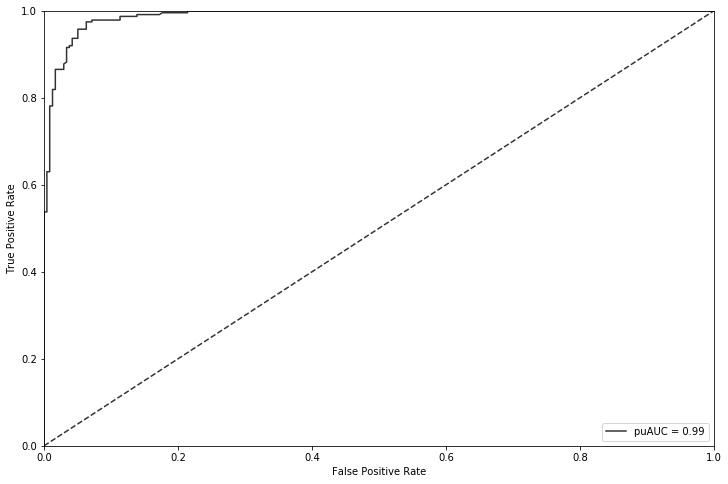

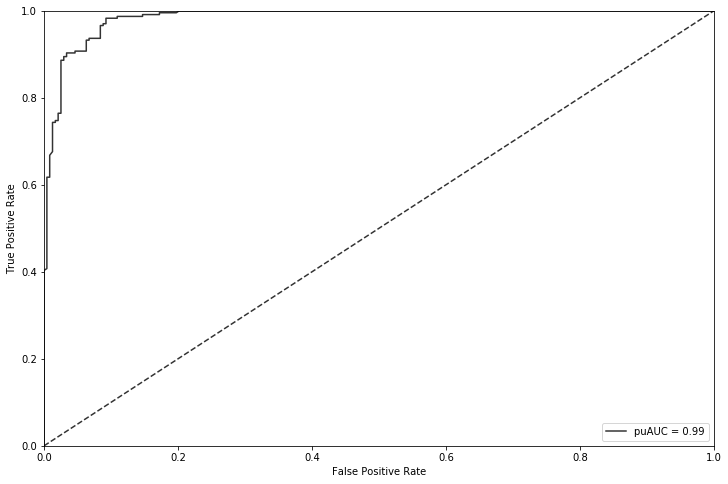

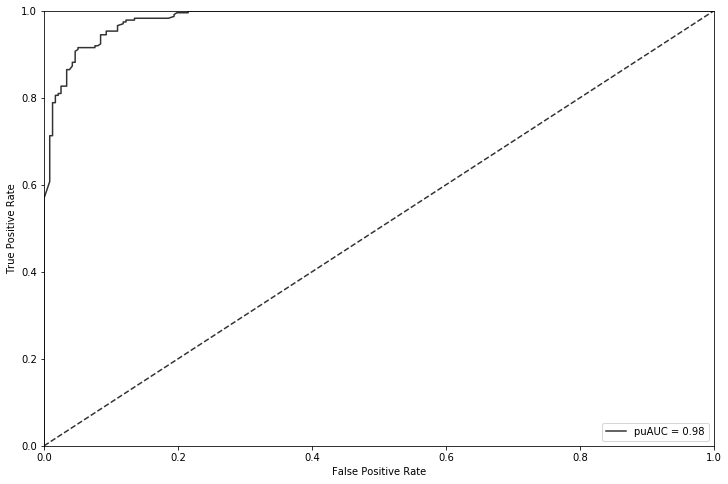

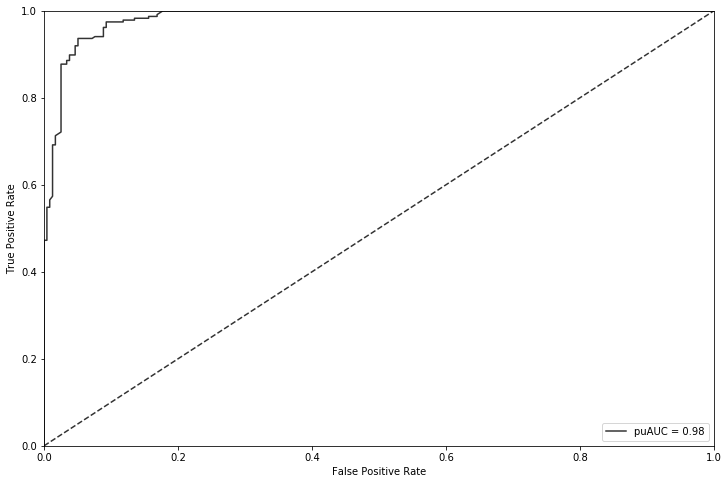

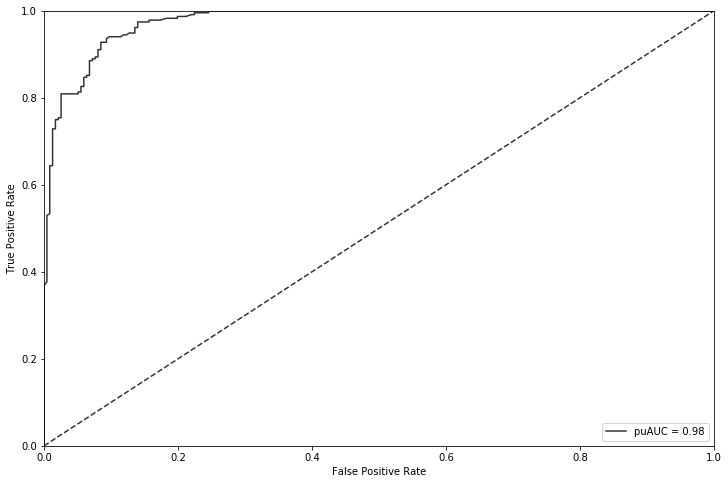

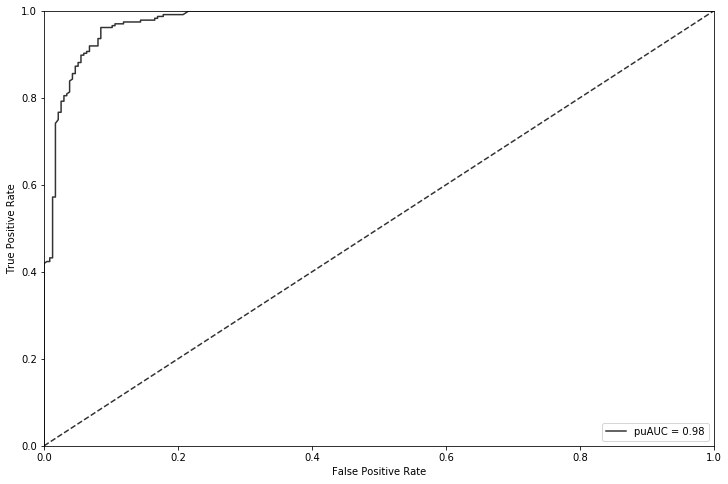

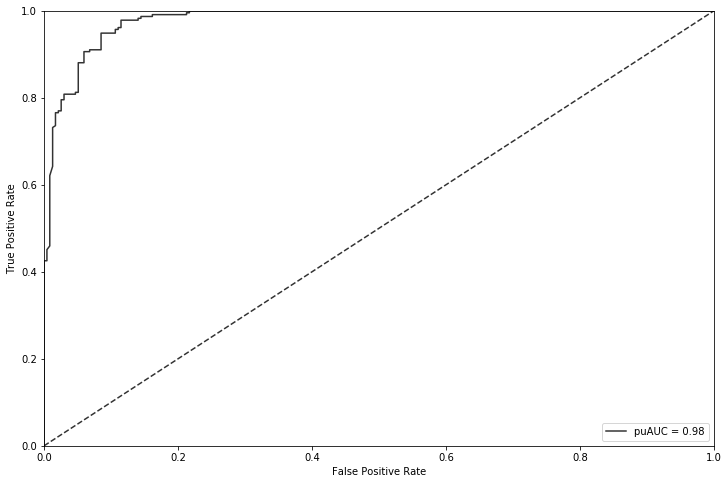

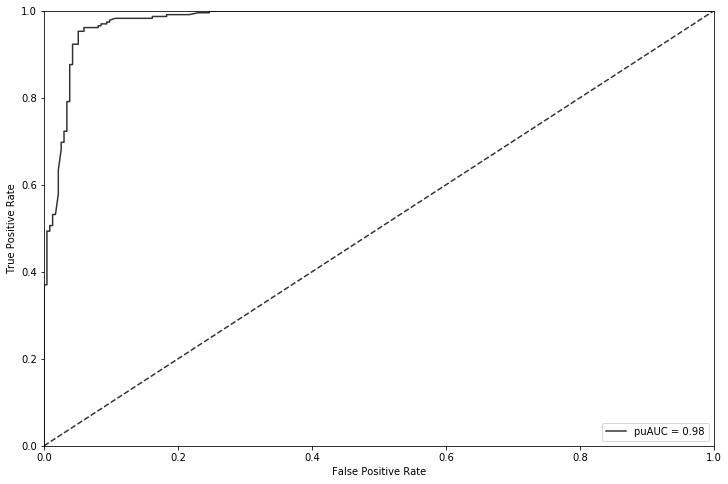

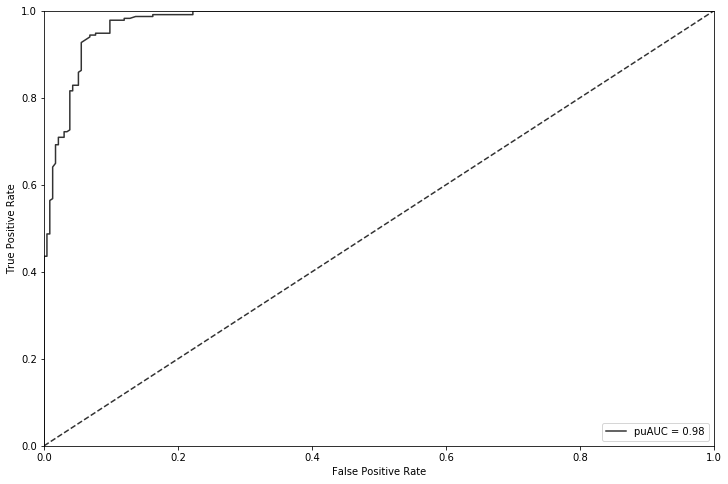

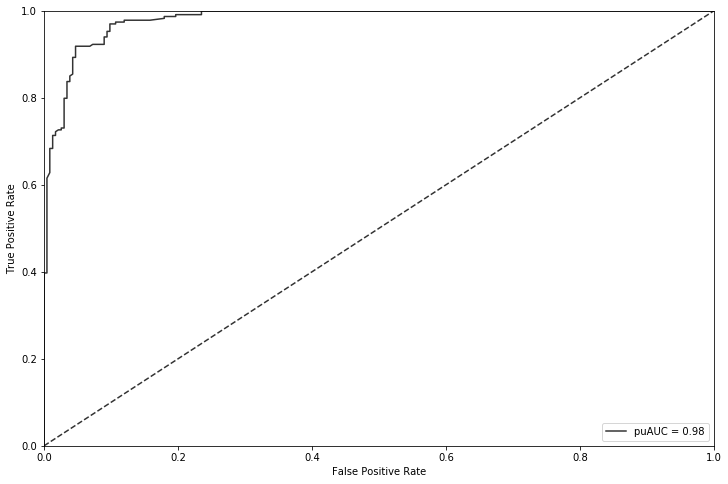

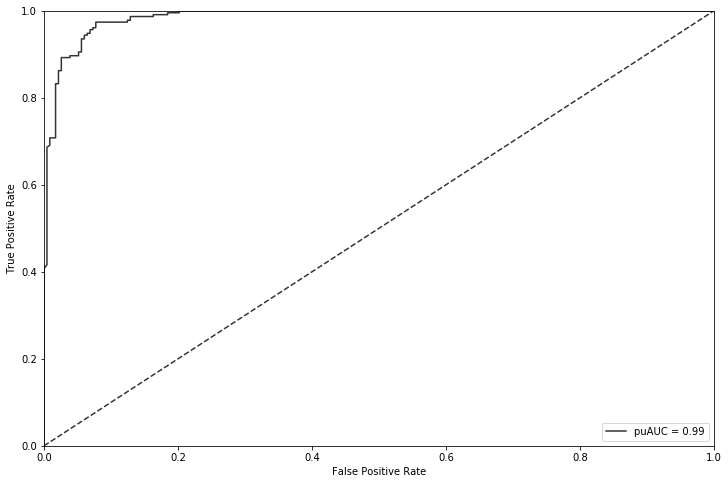

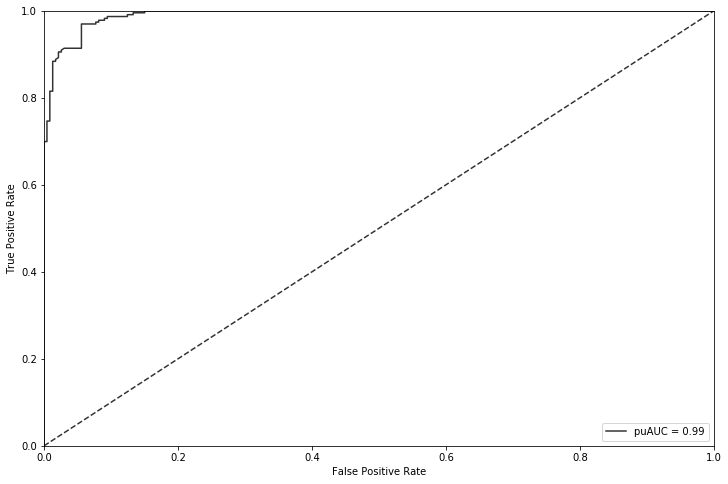

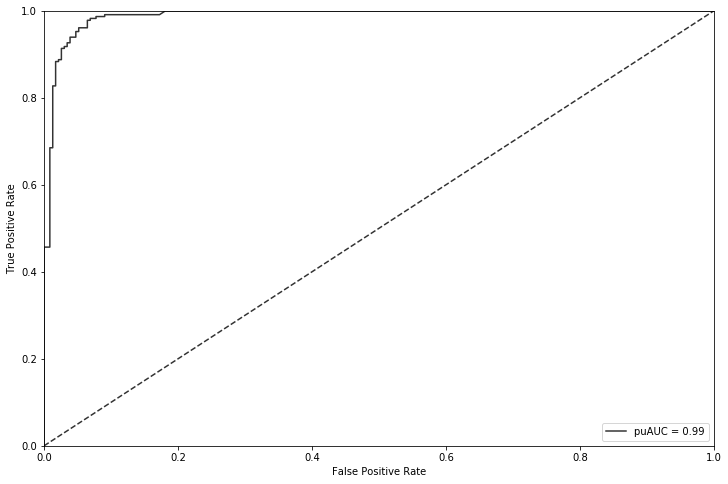

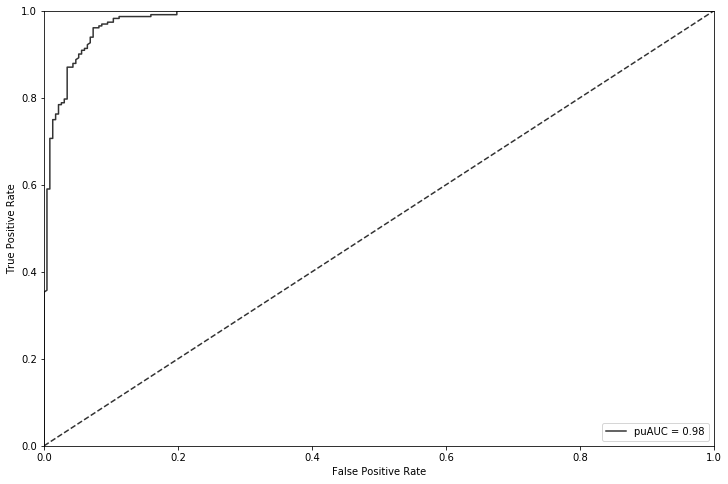

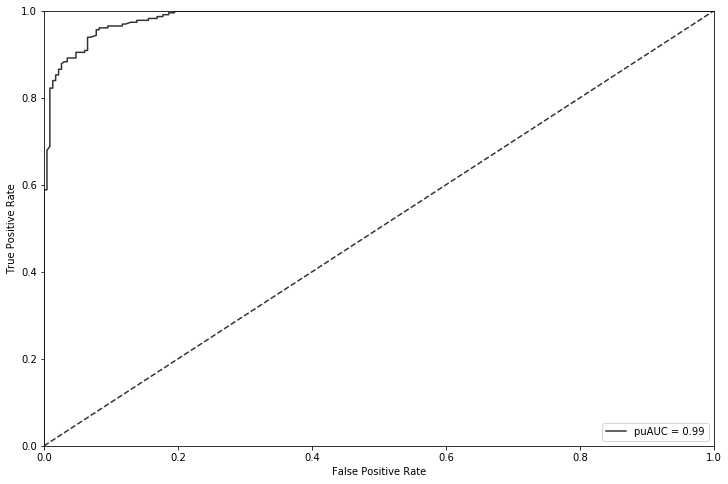

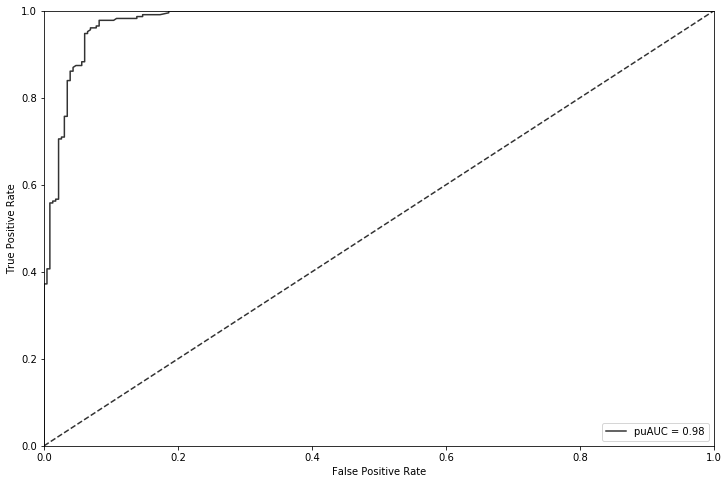

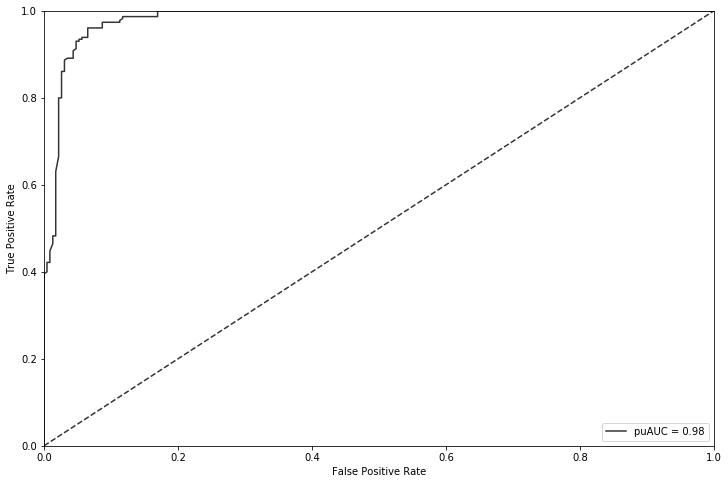

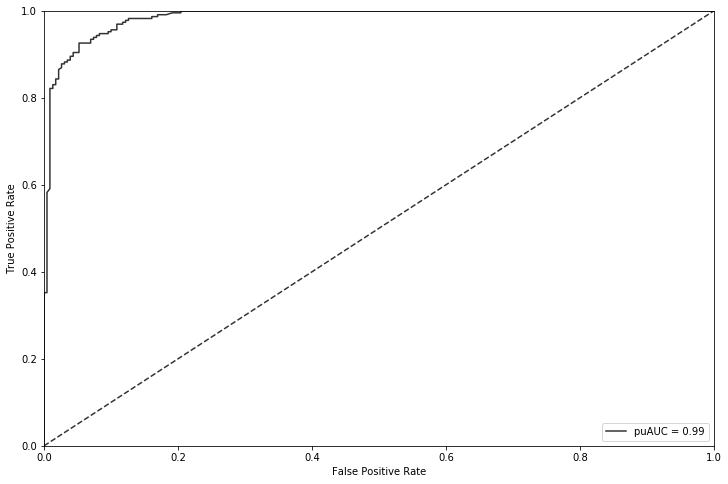

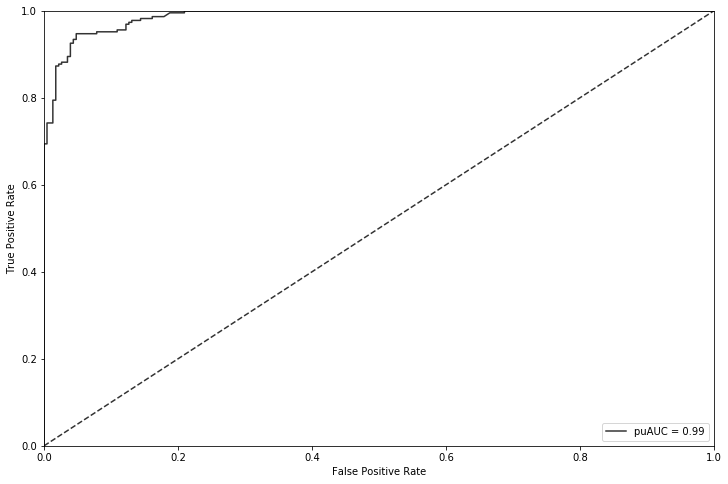

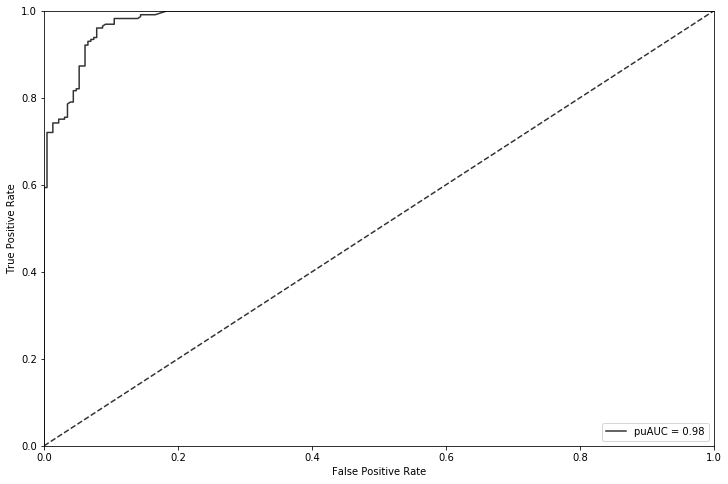

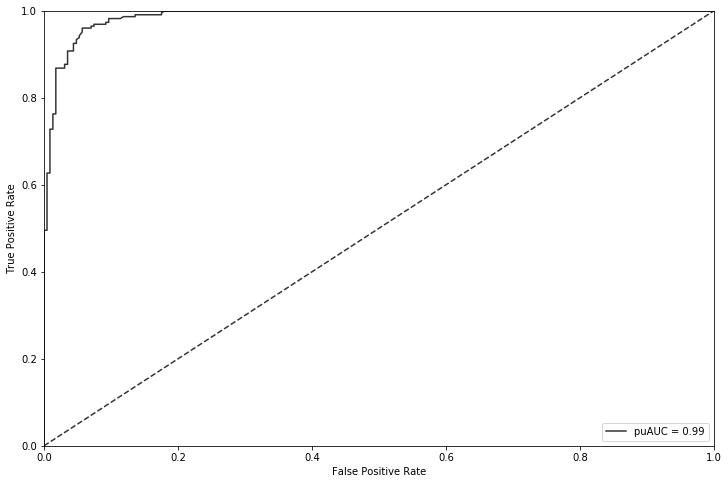

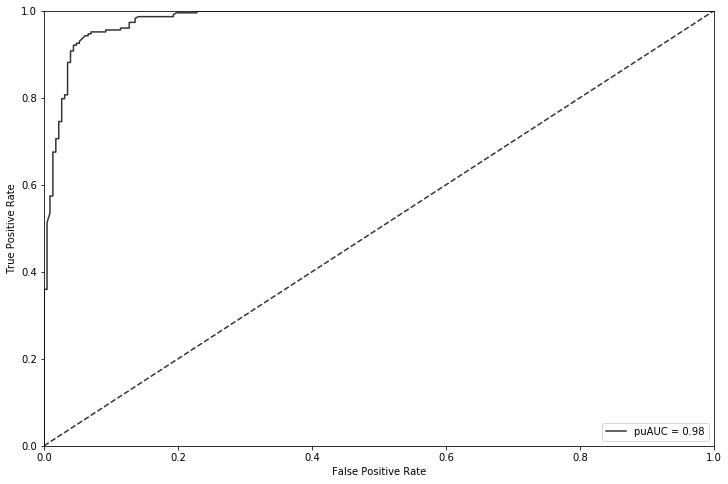

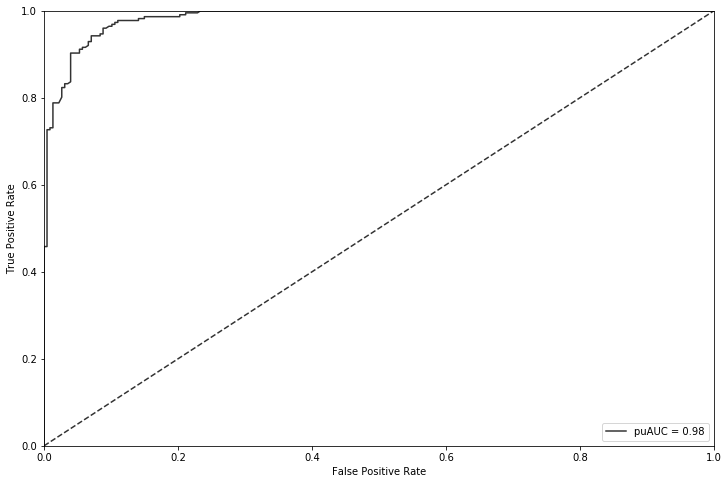

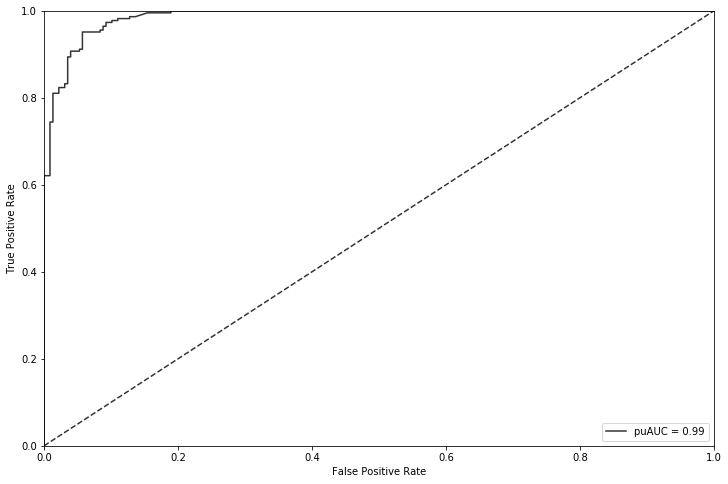

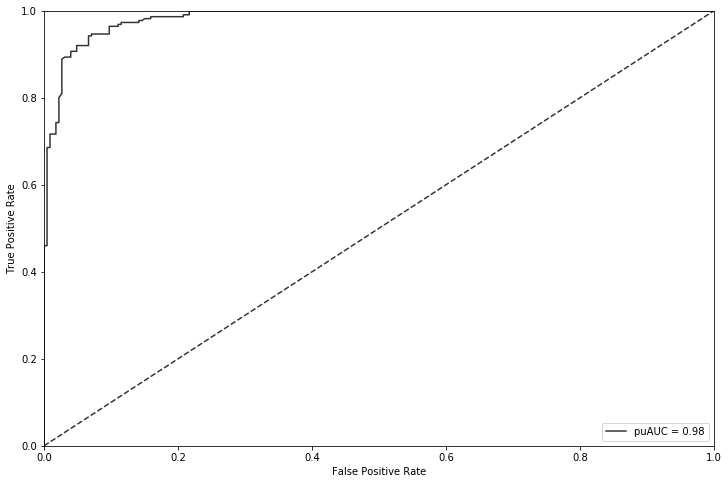

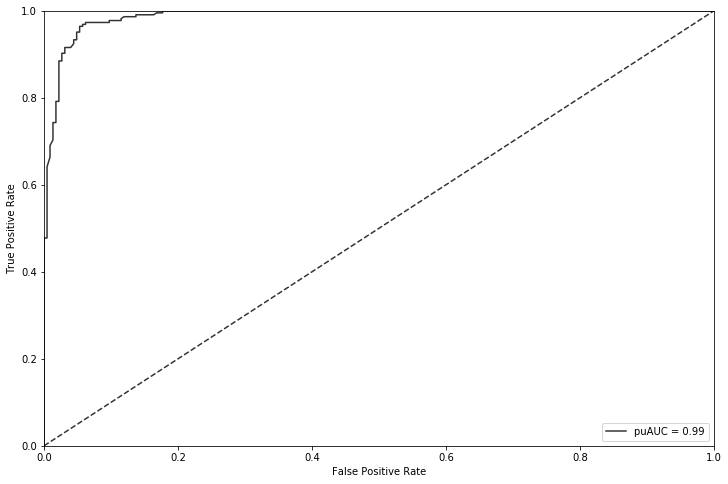

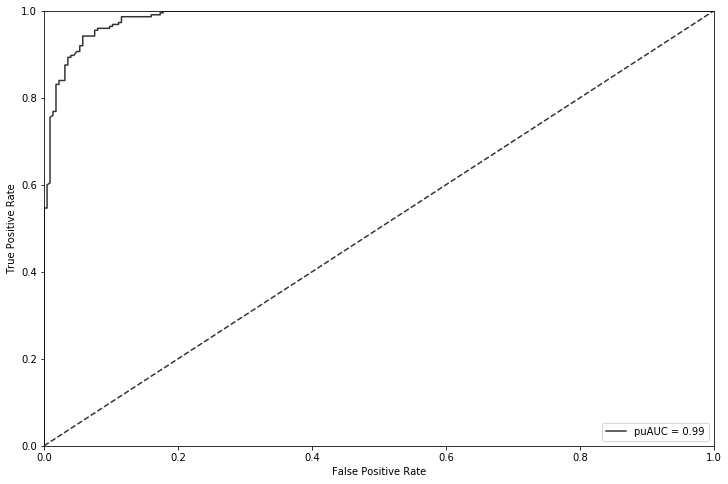

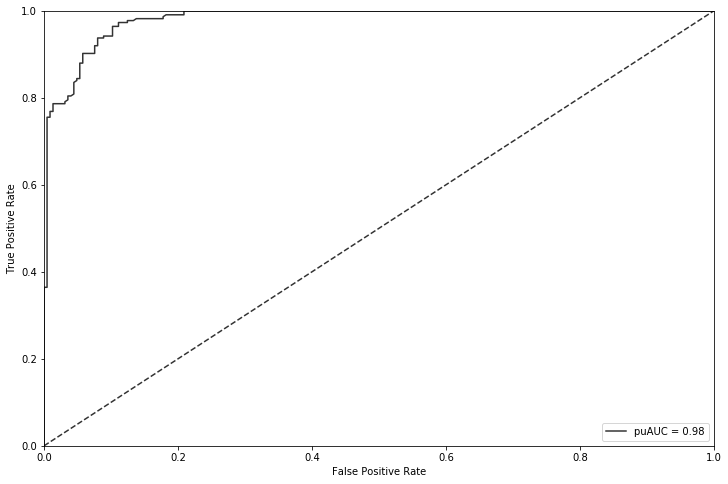

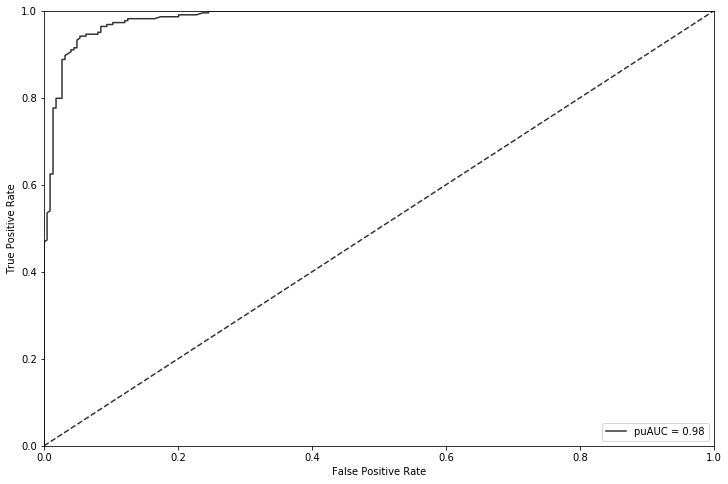

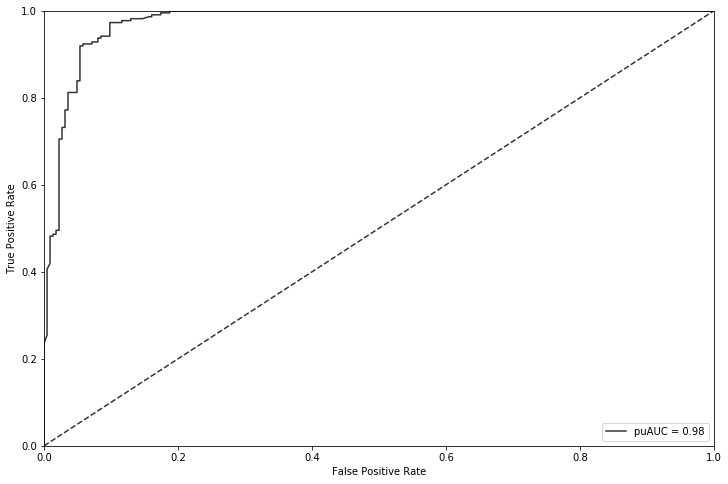

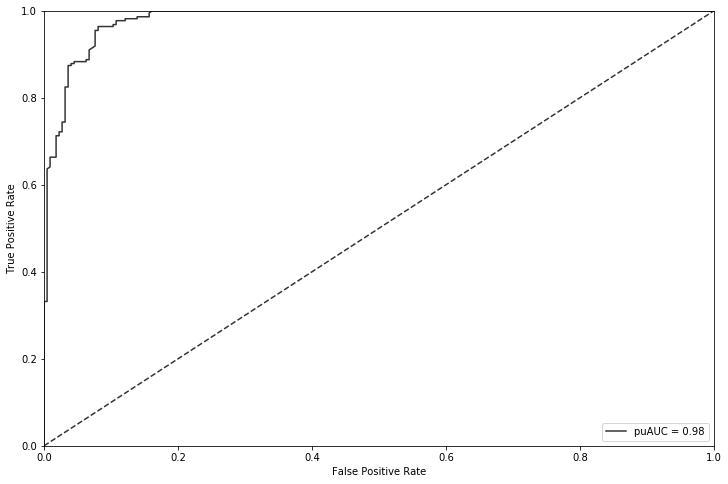

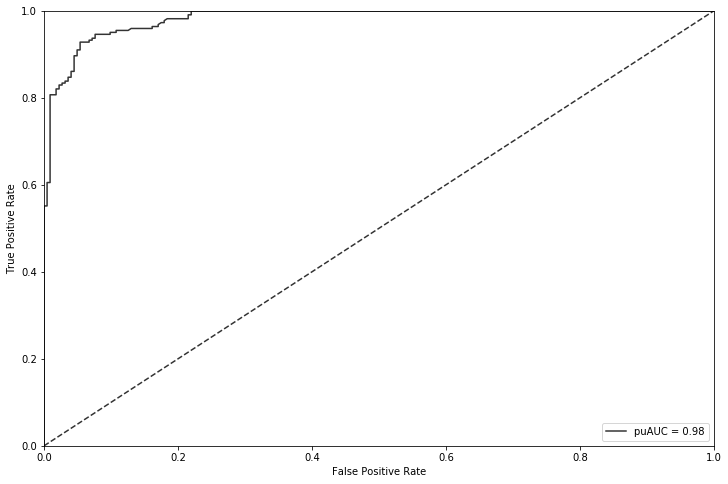

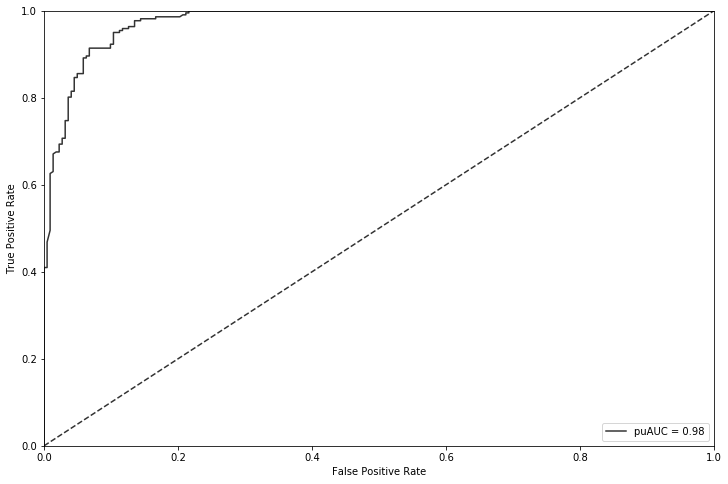

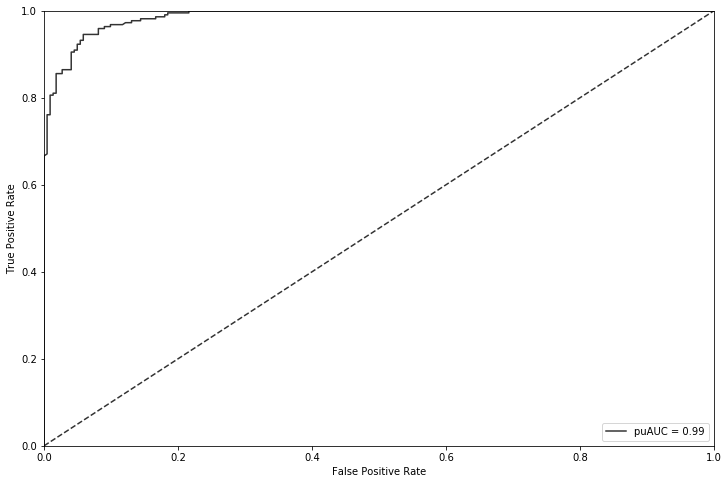

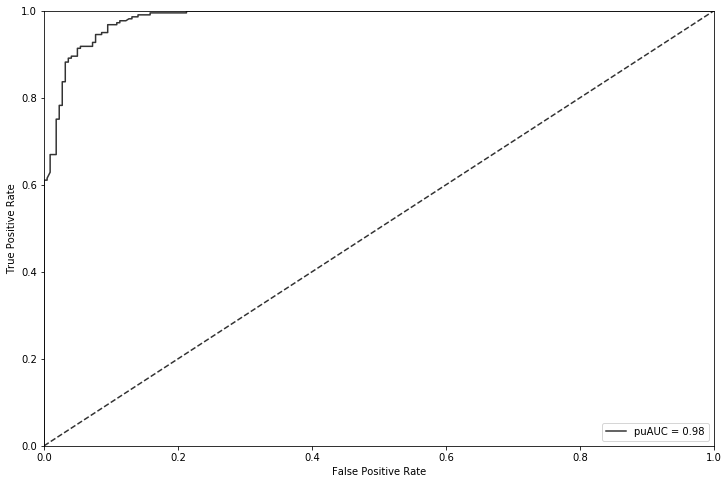

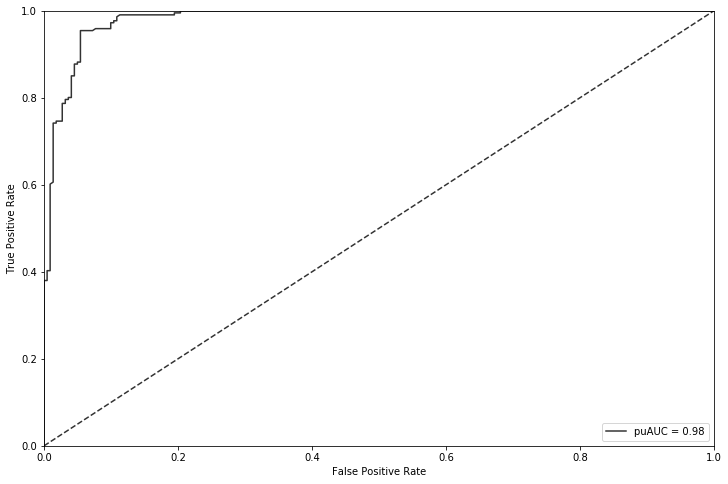

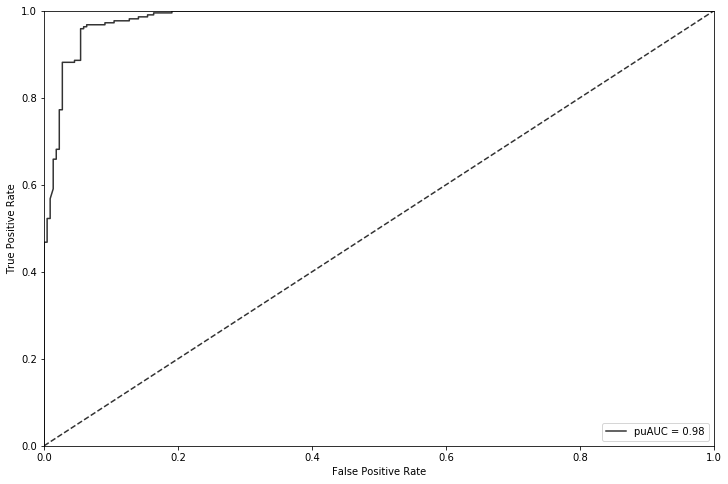

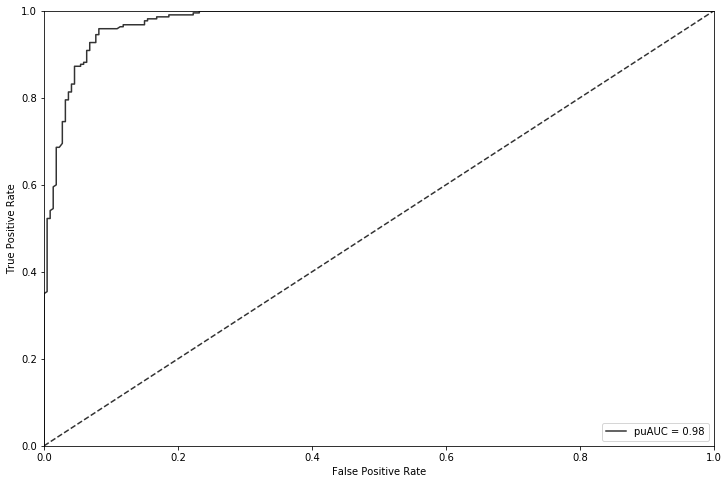

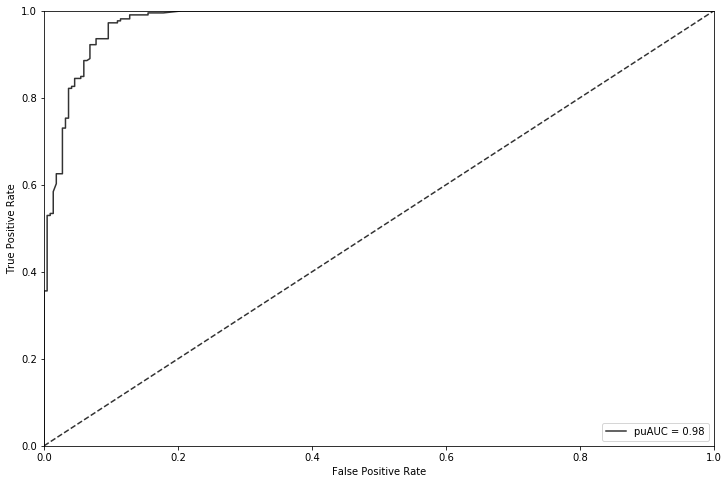

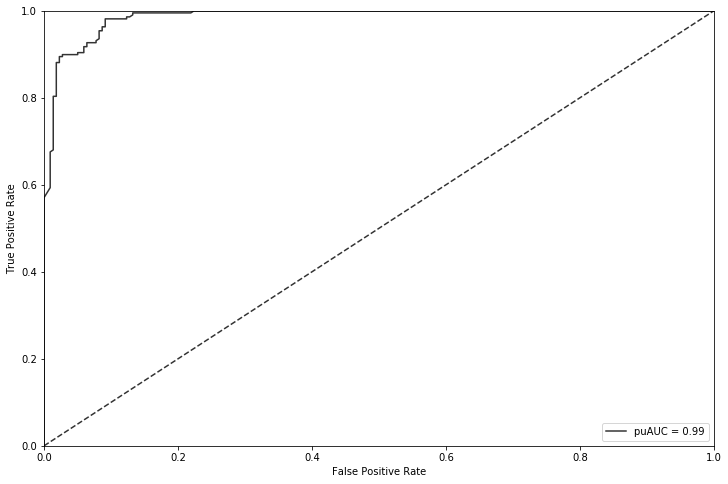

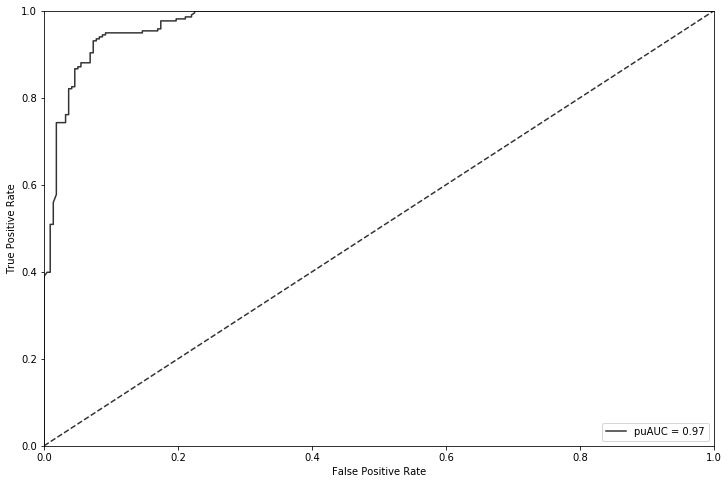

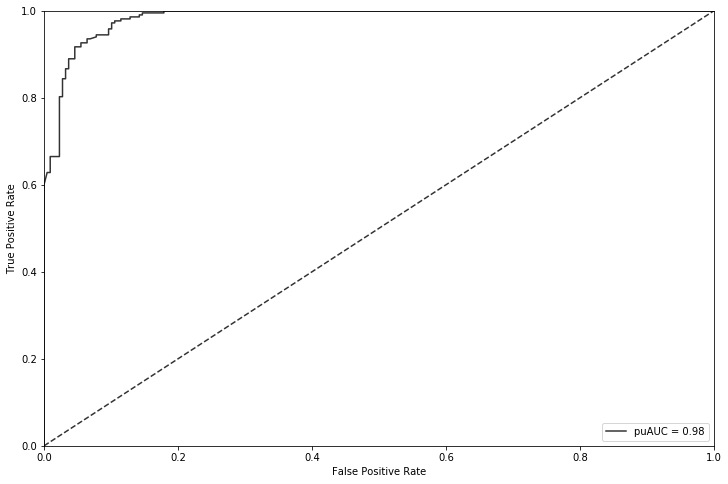

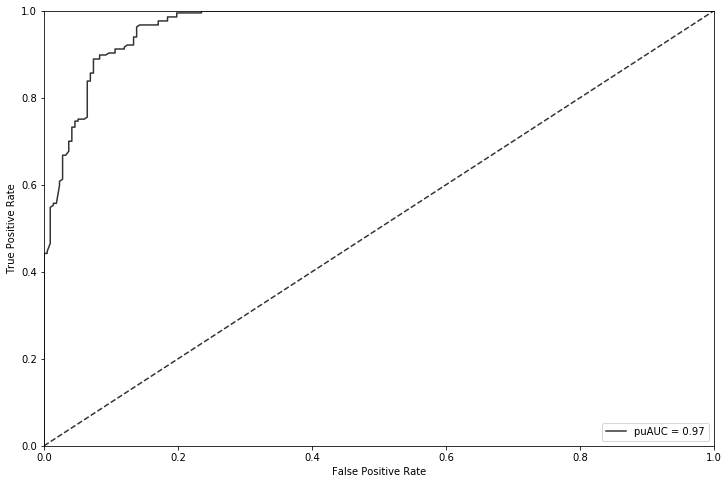

In [71]:
gbs = gbs_base.copy()

n = 579
iterations = 145
auroc = iterations*[0]

#feature importance
imp = (len(gbs.columns) -1) * [0]

for ite in range(iterations):
    
    gbs = gbs.reindex(np.random.permutation(gbs.index))

    fst = int(n/2) #first half
    lst = n - fst  #second half

    df_1 = gbs.head(fst).copy()
    df_2 = gbs.tail(lst).copy()

    train = pd.concat([rep.sample(n=lst), df_2], sort=True)
    test = pd.concat([rep.sample(n=fst), df_1], sort=True)

    y = train.Umfrage
    X = train.drop(columns=['Umfrage'], axis=1).copy()
    clf = RandomForestClassifier(n_estimators=150, max_depth=4)
    clf.fit(X, y)
    imp = [i+j for i,j in zip(clf.feature_importances_,imp)]

    y_test = test.Umfrage
    X_test = test.drop(columns=['Umfrage'], axis=1).copy()

    preds = [i[1] for i in clf.predict_proba(X_test)]
    auroc[ite] = roc(y_test, preds, ite/iterations, ite)
    
    rem = df_1.drop(columns = ['Umfrage'], axis=1)
    result = [i[1] for i in clf.predict_proba(rem)]
    
    if (gbs.index[np.argmax(result)] > 0.6):
        gbs = gbs.drop(gbs.index[np.argmax(result)]).copy()
        n = n-1
    else:
        print("Total number of iterations: " + str(579 - n))
        break
        
stats = gbs.describe()
stats = stats.round(2)
stats.to_csv(os.path.join(path, 'data/resultStats_allensbach.csv'), encoding = "ISO-8859-1", index= False)